In [14]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from utils.photometry.plot_utils import align_signal_to_events, plot_FP_with_licks, color_gradient
import numpy as np
from scipy.signal import butter, filtfilt, medfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
import pickle
# %matplotlib inline
# %matplotlib widget

In [9]:
session = 'm749472d20241230'
label = 'Gi'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)
parsed_licks_R, _ = parse_lick_trains(licks_R)
signal_region = load_session_FP(session, label, plot=False);
signal_region_raw = load_session_FP_raw(session, label, plot=False);

Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region TH recorded at fiber 1
Channel G:Region Gi recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region TH recorded at fiber 1
Channel Iso:Region Gi recorded at fiber 2


Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region TH recorded at fiber 1
Channel G:Region Gi recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region TH recorded at fiber 1
Channel Iso:Region Gi recorded at fiber 2
Preprocessing GmPFC
No exponential decay detected for GmPFC
Preprocessing GTH
Potential non-neuronal signal in GTH
1e-06
Preprocessing GGi
1e-06
Preprocessing IsomPFC
No exponential decay detected for IsomPFC
Preprocessing IsoTH
Potential non-neuronal signal in IsoTH
1e-06
Preprocessing IsoGi
1e-06


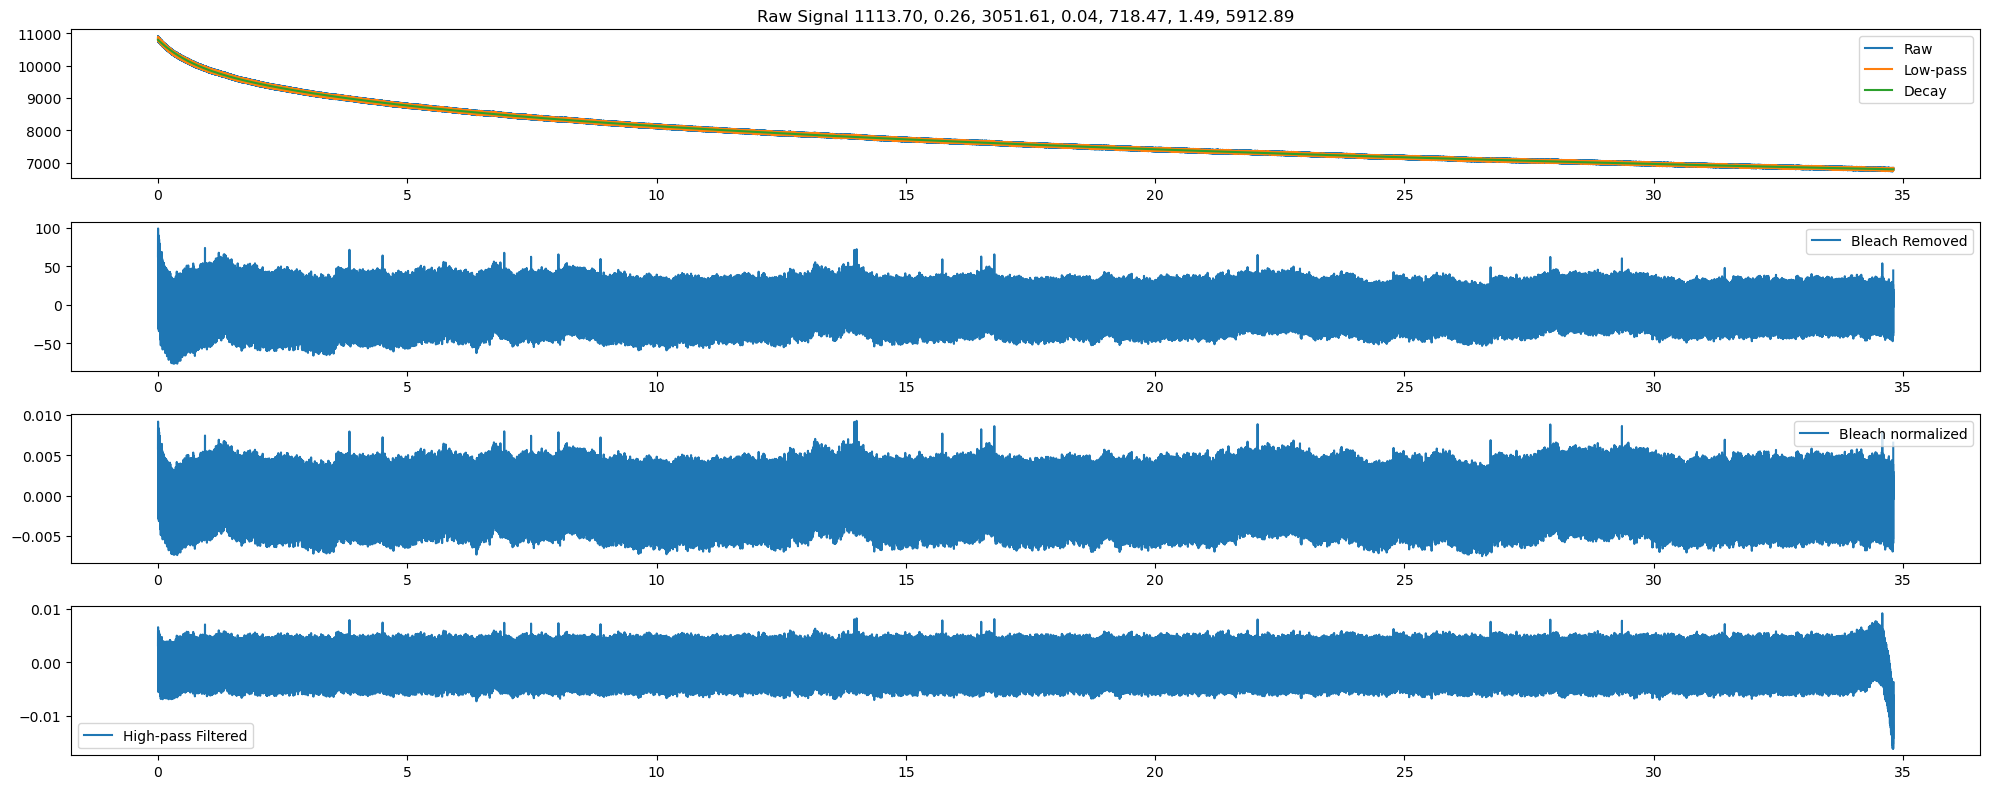

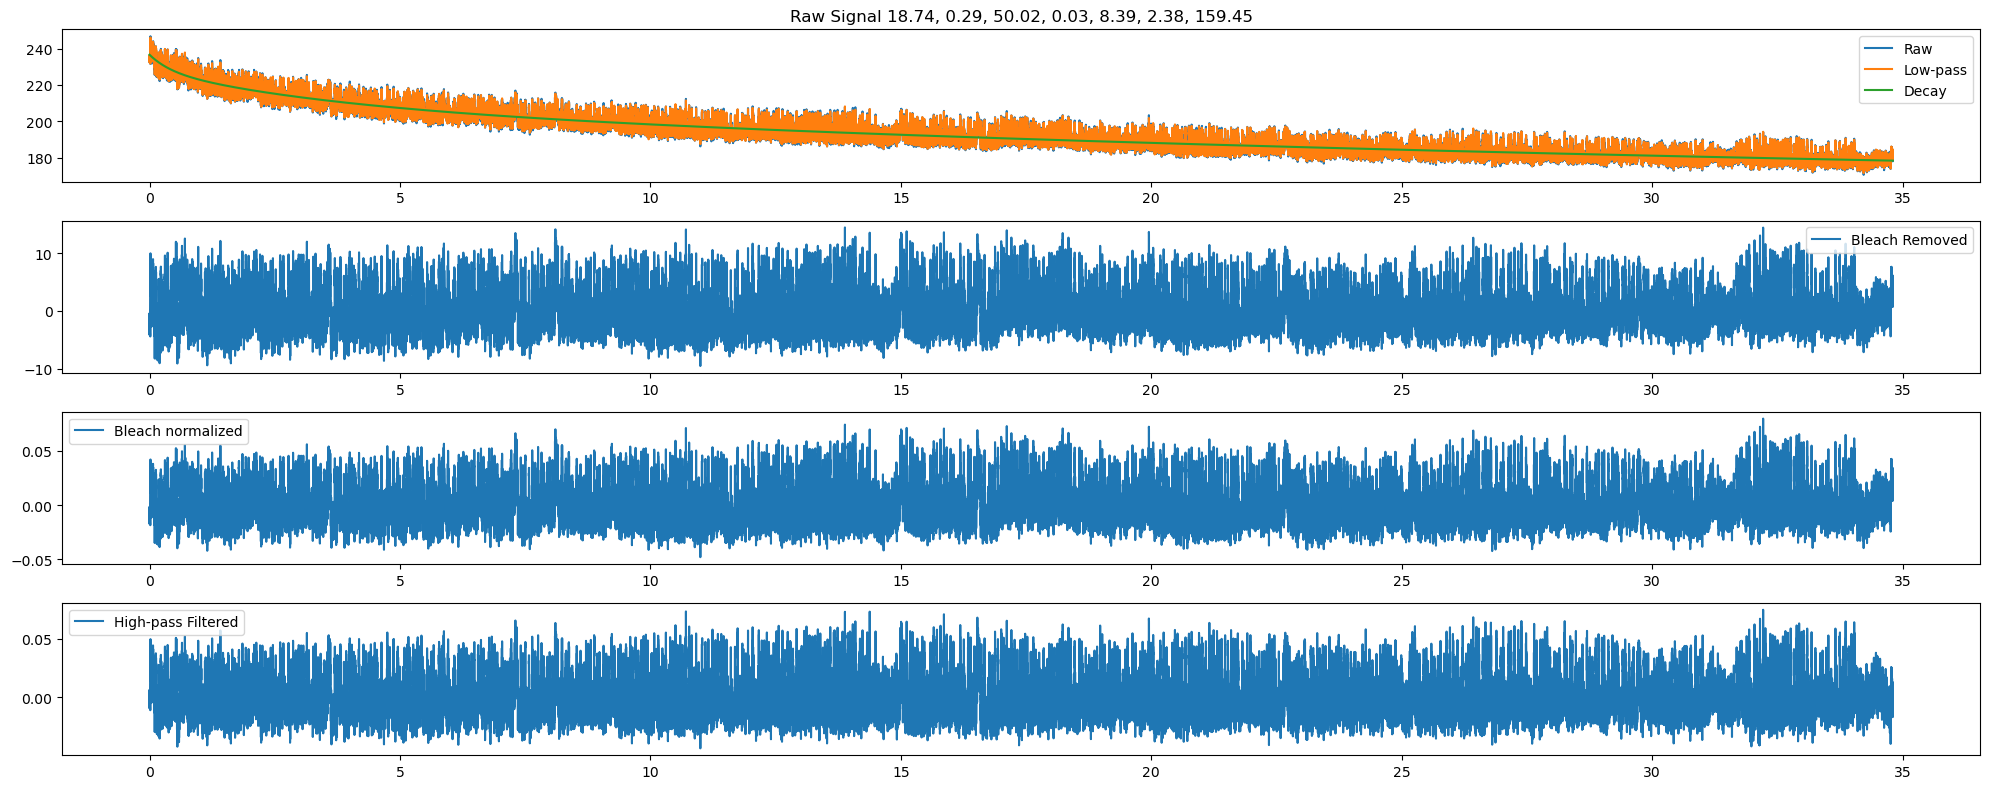

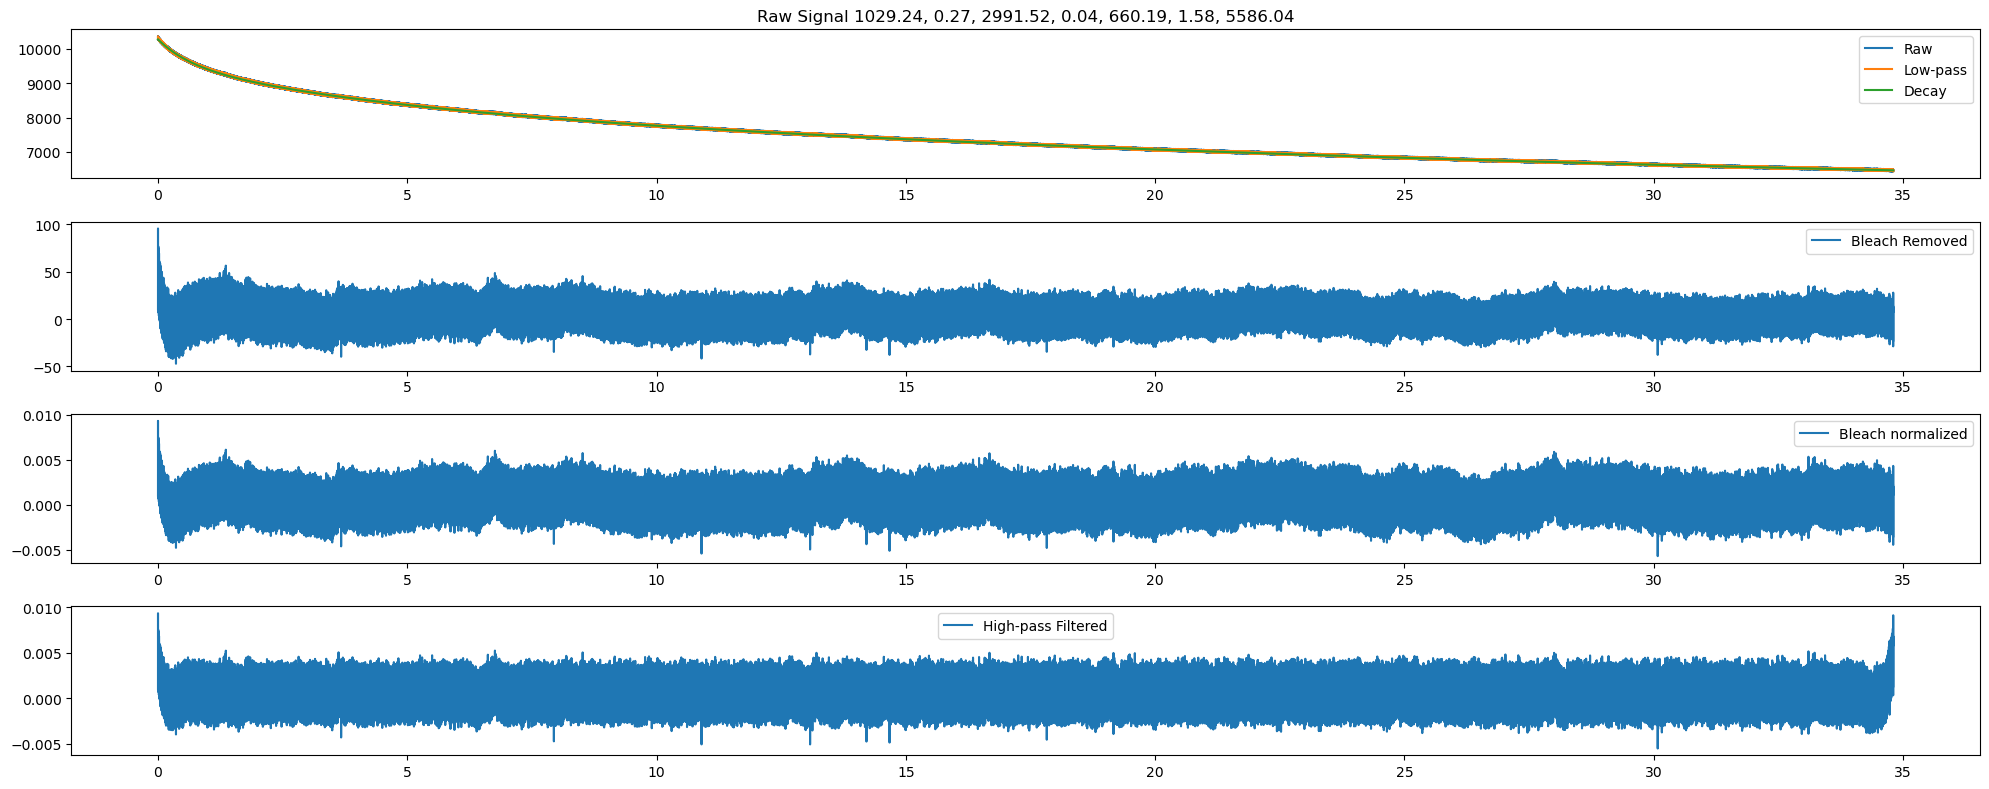

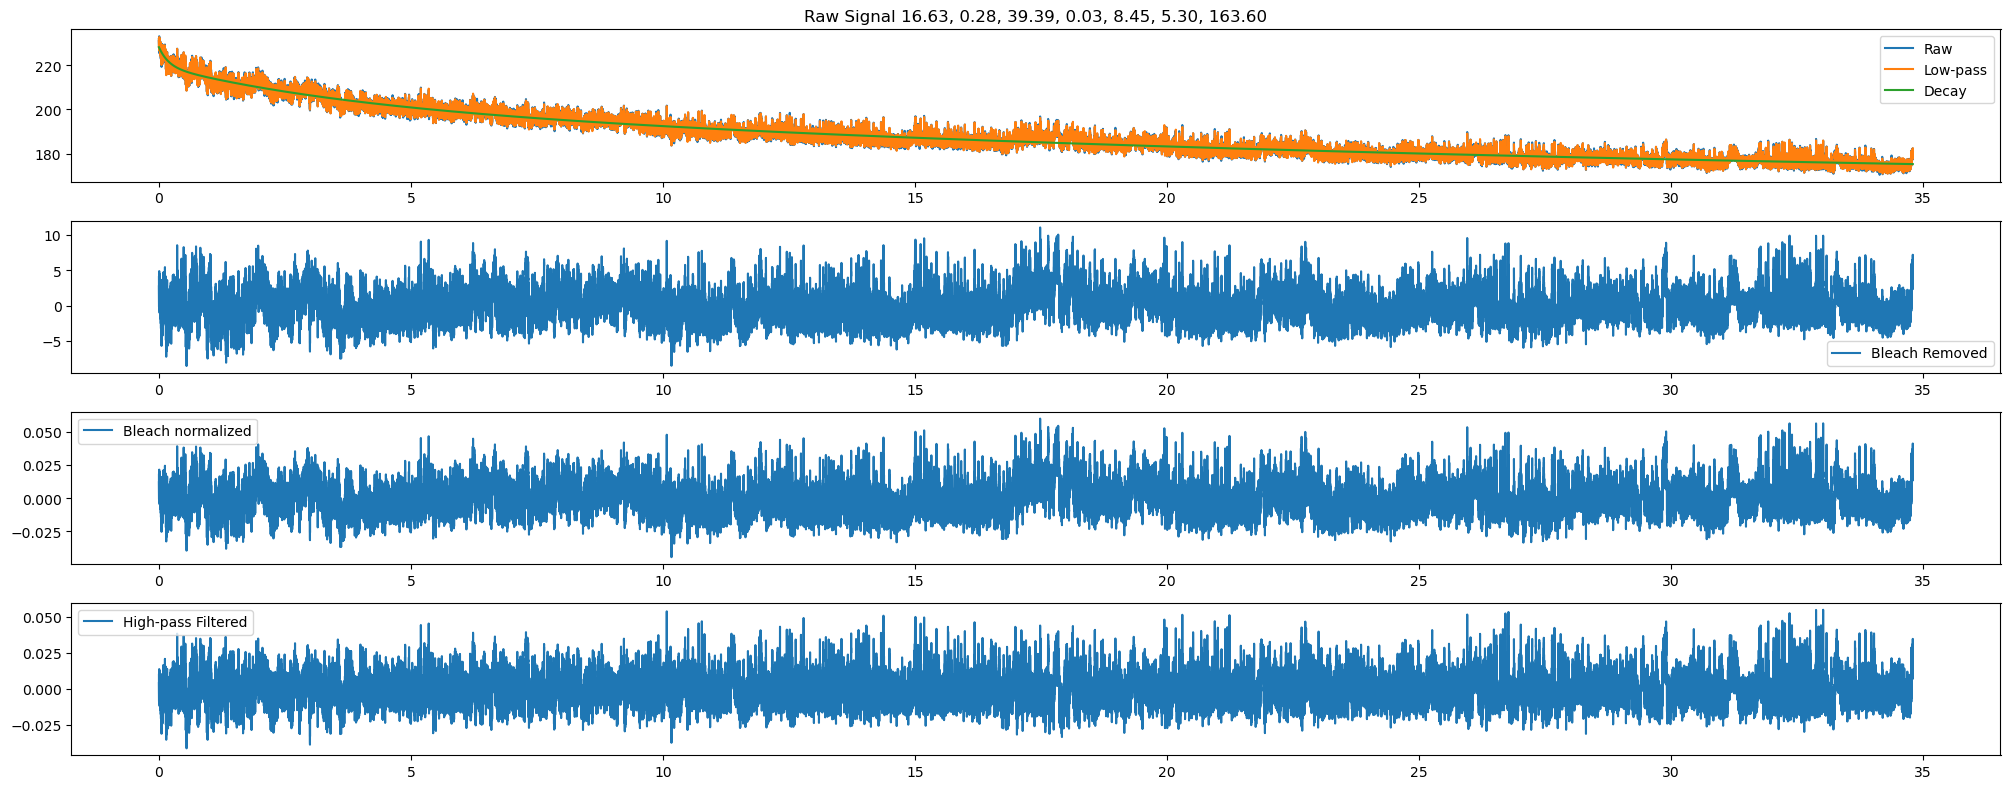

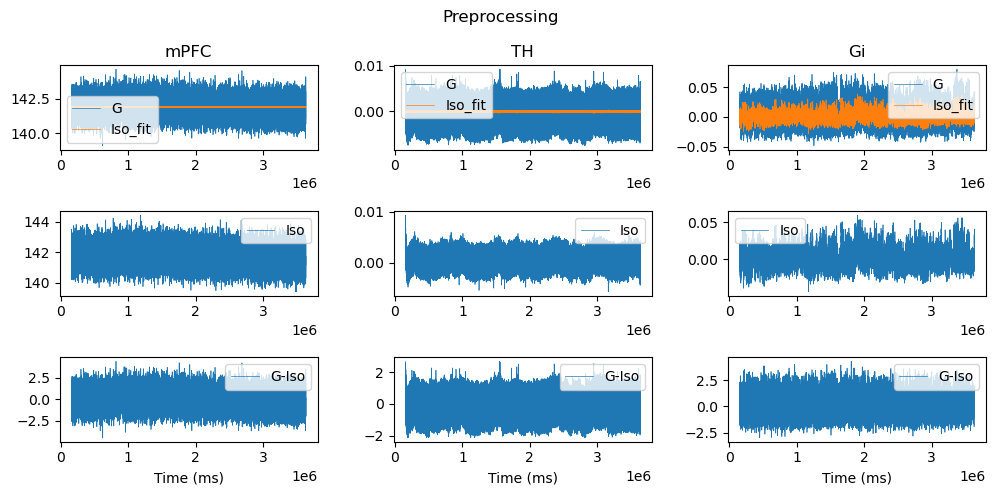

In [2]:
session = 'm754895d20250101'
label = 'Gi'
signal_region_raw = load_session_FP_raw(session, label, plot=False);
signal_pre = preprocess_signal(session, signal_region_raw, fs = 20, lowcut = 0.1, fc = 9, xtol=1e-6, plot=True)

Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region TH recorded at fiber 1
Channel G:Region Gi recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region TH recorded at fiber 1
Channel Iso:Region Gi recorded at fiber 2
Preprocessing GmPFC
No exponential decay detected for GmPFC
Preprocessing GTH
Potential non-neuronal signal in GTH
Preprocessing GGi
Preprocessing IsomPFC
No exponential decay detected for IsomPFC
Preprocessing IsoTH
Potential non-neuronal signal in IsoTH


KeyboardInterrupt: 

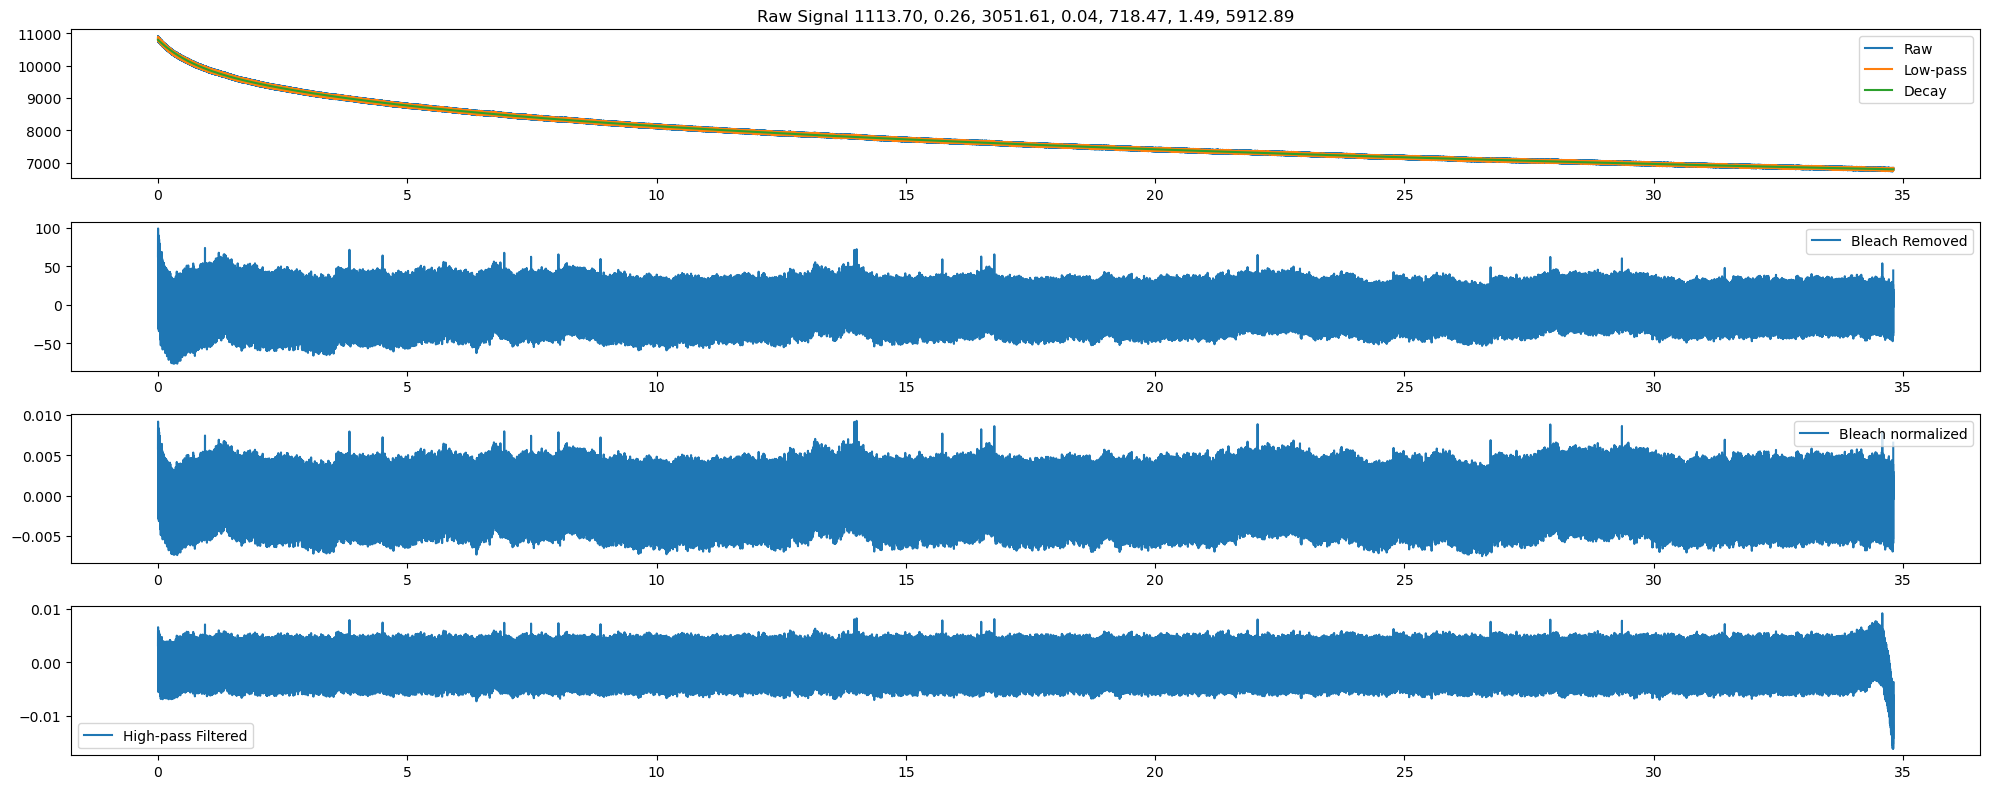

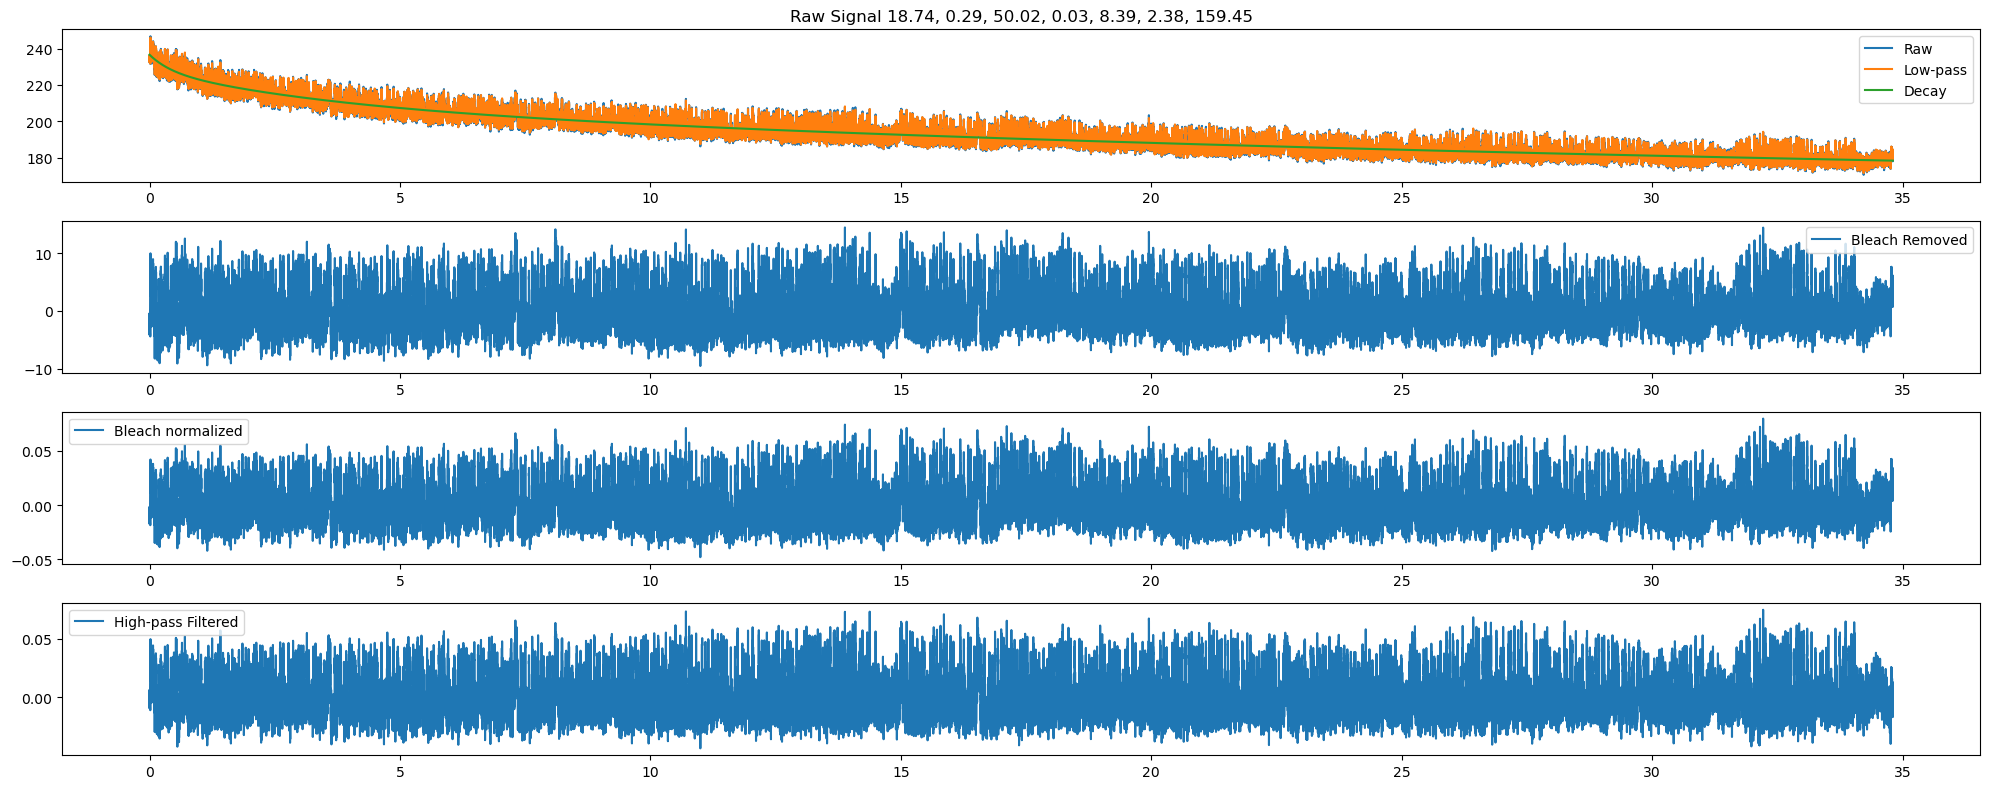

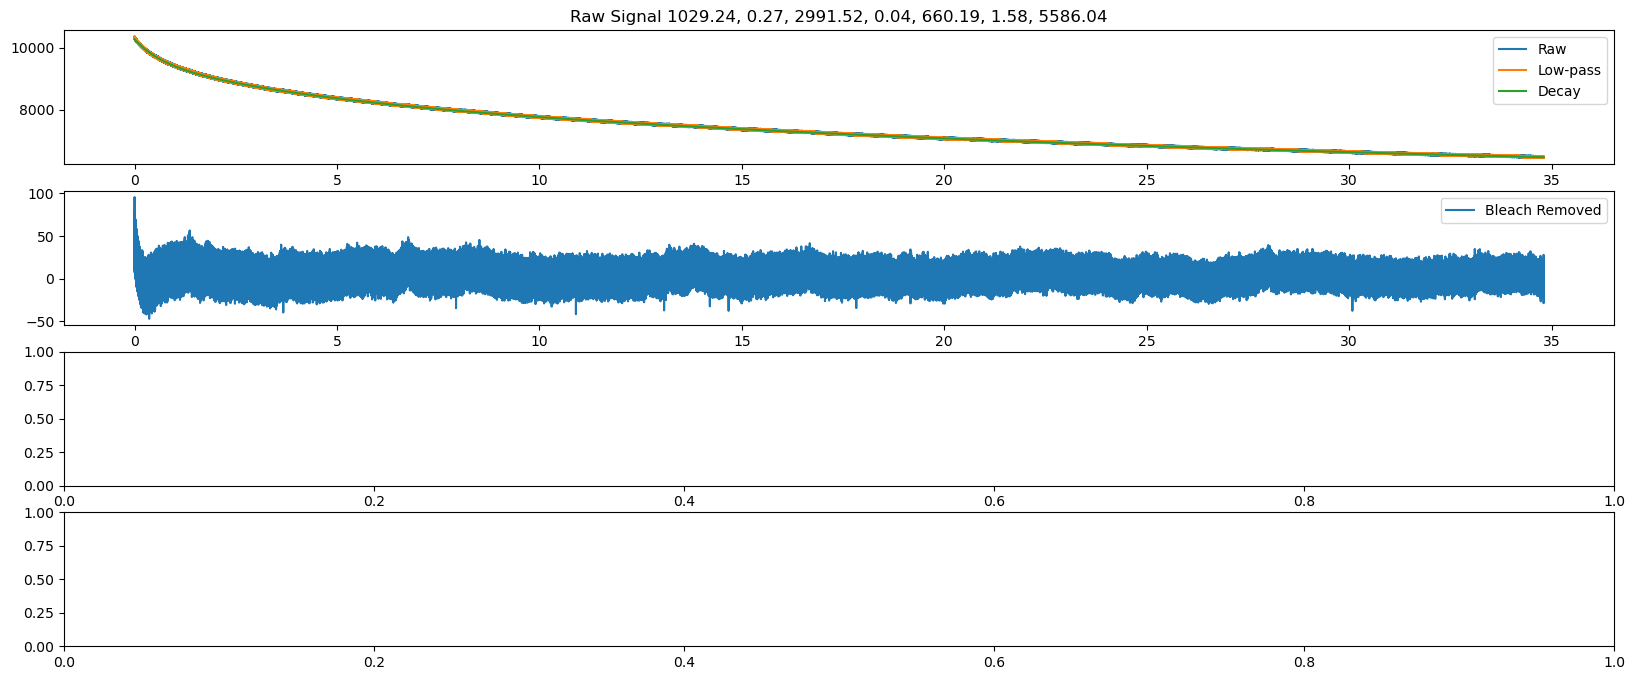

In [9]:
session = 'm754895d20250101'
label = 'Gi'
signal_region_raw = load_session_FP_raw(session, label, plot=False);
signal_pre = preprocess_signal(session, signal_region_raw, fs = 20, lowcut = 0.1, fc = 9, xtol=1e-2, plot=True)

In [10]:
def plot_FP_with_licks_test(session, label, region):
    session_df, licks_L, licks_R = load_session_df(session)
    session_dir = parse_session_string(session)
    signal_region_prep = get_FP_data(session, label)
    licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
    parsed_licks_L, _ = parse_lick_trains(licks_L)
    parsed_licks_R, _ = parse_lick_trains(licks_R)
    trial_starts = session_df['CSon']
    licks_in_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_in_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_out_trial_L = [train_start for train_start in list(parsed_licks_L['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    licks_out_trial_R = [train_start for train_start in list(parsed_licks_R['train_starts']) if not any([trial_start<train_start and trial_start>train_start-2000  for trial_start in trial_starts])]
    fig = plt.figure(figsize=(15, 8))
    colorL = 'b'
    colorR = 'r'
    all_channels = [key for key, value in signal_region_prep.items() if 'time' not in key]
    gs = GridSpec(len(all_channels), 5, figure=fig)
    for channel_id, channel in enumerate(all_channels):
        signal = signal_region_prep[channel][region]
        ax = fig.add_subplot(gs[channel_id, 0])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_L['train_starts'], ax = ax, legend = 'L', color = colorL)
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], parsed_licks_R['train_starts'], ax = ax, legend = 'R', color = colorR)
        ax.legend()
        ax.set_title(f'All licks')
        ax.set_ylabel(channel)
        # in vs out trial L
        ax = fig.add_subplot(gs[channel_id, 1])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_L, ax = ax, color = colorL, legend = 'in')
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_L, ax = ax, color = colorR, legend = 'out')
        ax.legend()
        ax.set_title(f'In vs out trial L')
        # in vs out trial R
        ax = fig.add_subplot(gs[channel_id, 2])
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_in_trial_R, ax = ax, color = colorL, legend = 'in')     
        align_signal_to_events(signal, signal_region_prep['time_in_beh'], licks_out_trial_R, ax = ax, color = colorR, legend = 'out')
        ax.legend()
        ax.set_title(f'In vs out trial R')
        # in left, in vs out trial with gradient of lick lick peak
        ax = fig.add_subplot(gs[channel_id, 3])
        num_bins = 3
        peaks = parsed_licks_L['train_amps']
        colors_in = color_gradient([1, 0, 0], num_bins+1)
        colors_out = color_gradient([0, 0, 1], num_bins+1)
        edges = np.quantile(peaks, np.linspace(0, 1, num_bins+1))
        for ind in range(num_bins):
            mask = (peaks>edges[ind]) & (peaks<=edges[ind+1])
            if np.sum(mask)>2:
                align_signal_to_events(signal, signal_region_prep['time_in_beh'], np.array(parsed_licks_L['train_starts'])[mask], ax = ax, color = colors_in[ind+1], legend = f'In trial bin {ind}', plot_error=False)
        ax.set_title(f'Left licks by lick peak')
        # in right, in vs out trial with gradient of lick lick peak\
        ax = fig.add_subplot(gs[channel_id, 4])
        peaks = parsed_licks_R['train_amps']
        colors_in = color_gradient([0, 0, 1], num_bins+1)
        colors_out = color_gradient([0, 0, 1], num_bins+1)
        edges = np.quantile(peaks, np.linspace(0, 1, num_bins+1))
        edges[0] = edges[0]-0.01
        for ind in range(num_bins):
            mask = (peaks>edges[ind]) & (peaks<=edges[ind+1])
            if np.sum(mask)>2:
                align_signal_to_events(signal, signal_region_prep['time_in_beh'], np.array(parsed_licks_R['train_starts'])[mask], ax = ax, color = colors_in[ind+1], legend = f'In trial bin {ind}', plot_error=False)  
        ax.set_title(f'Right licks by lick peak')
    fig.suptitle(f'{session}_{region}')
    plt.tight_layout()

    fig.savefig(os.path.join(session_dir['saveFigFolder'], f'{session}_{region}_FP_licks.pdf'))

In [11]:
session_list = get_session_list('photometry', 'all', 'crusIgood')
label = 'CombinewithKH'

In [39]:
for session in session_list[21:]:
    print(session)
    get_FP_data(session, label)
    plot_FP_with_licks_test(session, label, 'CrusI')
    plot_FP_with_licks_test(session, label, 'mPFC')  
    plot_FP_with_licks_test(session, label, 'LC')  
    plt.close('all')
    # plot_FP_with_licks_test(session, label, 'TH')
    # plot_FP_with_licks_test(session, label, 'mPFC')
    plt.close('all')

m699462d20240113
Loaded m699462d20240113_FP_CombinewithKH.pkl
Loaded m699462d20240113_FP_CombinewithKH.pkl
Loaded m699462d20240113_FP_CombinewithKH.pkl
Loaded m699462d20240113_FP_CombinewithKH.pkl
m699462d20240114
Loaded m699462d20240114_FP_CombinewithKH.pkl
Loaded m699462d20240114_FP_CombinewithKH.pkl
Loaded m699462d20240114_FP_CombinewithKH.pkl
Loaded m699462d20240114_FP_CombinewithKH.pkl
m699462d20240116
Loaded m699462d20240116_FP_CombinewithKH.pkl
Loaded m699462d20240116_FP_CombinewithKH.pkl
Loaded m699462d20240116_FP_CombinewithKH.pkl
Loaded m699462d20240116_FP_CombinewithKH.pkl
m699462d20240117
Loaded m699462d20240117_FP_CombinewithKH.pkl
Loaded m699462d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699462d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699462d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20231221
Loaded m699472d20231221_FP_CombinewithKH.pkl
Loaded m699472d20231221_FP_CombinewithKH.pkl
Loaded m699472d20231221_FP_CombinewithKH.pkl
Loaded m699472d20231221_FP_CombinewithKH.pkl
m699472d20231222
Loaded m699472d20231222_FP_CombinewithKH.pkl
Loaded m699472d20231222_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20231222_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20231222_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240102
Loaded m699472d20240102_FP_CombinewithKH.pkl
Loaded m699472d20240102_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240102_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240102_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240103
Loaded m699472d20240103_FP_CombinewithKH.pkl
Loaded m699472d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240104
Loaded m699472d20240104_FP_CombinewithKH.pkl
Loaded m699472d20240104_FP_CombinewithKH.pkl
Loaded m699472d20240104_FP_CombinewithKH.pkl
Loaded m699472d20240104_FP_CombinewithKH.pkl
m699472d20240105
Loaded m699472d20240105_FP_CombinewithKH.pkl
Loaded m699472d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240106
Loaded m699472d20240106_FP_CombinewithKH.pkl
Loaded m699472d20240106_FP_CombinewithKH.pkl
Loaded m699472d20240106_FP_CombinewithKH.pkl
Loaded m699472d20240106_FP_CombinewithKH.pkl
m699472d20240107
Loaded m699472d20240107_FP_CombinewithKH.pkl
Loaded m699472d20240107_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240107_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240107_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240108
Loaded m699472d20240108_FP_CombinewithKH.pkl
Loaded m699472d20240108_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240108_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240108_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240109
Loaded m699472d20240109_FP_CombinewithKH.pkl
Loaded m699472d20240109_FP_CombinewithKH.pkl
Loaded m699472d20240109_FP_CombinewithKH.pkl
Loaded m699472d20240109_FP_CombinewithKH.pkl
m699472d20240110
Loaded m699472d20240110_FP_CombinewithKH.pkl
Loaded m699472d20240110_FP_CombinewithKH.pkl
Loaded m699472d20240110_FP_CombinewithKH.pkl
Loaded m699472d20240110_FP_CombinewithKH.pkl
m699472d20240111
Loaded m699472d20240111_FP_CombinewithKH.pkl
Loaded m699472d20240111_FP_CombinewithKH.pkl
Loaded m699472d20240111_FP_CombinewithKH.pkl
Loaded m699472d20240111_FP_CombinewithKH.pkl
m699472d20240112
Loaded m699472d20240112_FP_CombinewithKH.pkl
Loaded m699472d20240112_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240112_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240112_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240113
Loaded m699472d20240113_FP_CombinewithKH.pkl
Loaded m699472d20240113_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240113_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240113_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m699472d20240114
Loaded m699472d20240114_FP_CombinewithKH.pkl
Loaded m699472d20240114_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:62: RuntimeWarning: Mean of empty slice
  mean_psth = np.nanmean(aligned_matrix, axis=0)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Loaded m699472d20240114_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:62: RuntimeWarning: Mean of empty slice
  mean_psth = np.nanmean(aligned_matrix, axis=0)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Loaded m699472d20240114_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:62: RuntimeWarning: Mean of empty slice
  mean_psth = np.nanmean(aligned_matrix, axis=0)
c:\Users\zhixi\Anaconda3\envs\playGround\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


m699472d20240117
Loaded m699472d20240117_FP_CombinewithKH.pkl
Loaded m699472d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m699472d20240117_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20231221
Loaded m701707d20231221_FP_CombinewithKH.pkl
Loaded m701707d20231221_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20231221_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20231221_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20231222
Loaded m701707d20231222_FP_CombinewithKH.pkl
Loaded m701707d20231222_FP_CombinewithKH.pkl
Loaded m701707d20231222_FP_CombinewithKH.pkl
Loaded m701707d20231222_FP_CombinewithKH.pkl
m701707d20240103
Loaded m701707d20240103_FP_CombinewithKH.pkl
Loaded m701707d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240103_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20240104
Loaded m701707d20240104_FP_CombinewithKH.pkl
Loaded m701707d20240104_FP_CombinewithKH.pkl
Loaded m701707d20240104_FP_CombinewithKH.pkl
Loaded m701707d20240104_FP_CombinewithKH.pkl
m701707d20240105
Loaded m701707d20240105_FP_CombinewithKH.pkl
Loaded m701707d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


Loaded m701707d20240105_FP_CombinewithKH.pkl


c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\photometry\plot_utils.py:60: RuntimeWarning: Mean of empty slice
  aligned_matrix[i, j] = np.nanmean(aligned_signal[window_mask])


m701707d20240106
Loaded m701707d20240106_FP_CombinewithKH.pkl
Loaded m701707d20240106_FP_CombinewithKH.pkl
Loaded m701707d20240106_FP_CombinewithKH.pkl
Loaded m701707d20240106_FP_CombinewithKH.pkl
m701707d20240112
Loaded m701707d20240112_FP_CombinewithKH.pkl
Loaded m701707d20240112_FP_CombinewithKH.pkl
Loaded m701707d20240112_FP_CombinewithKH.pkl
Loaded m701707d20240112_FP_CombinewithKH.pkl
m701707d20240113
Loaded m701707d20240113_FP_CombinewithKH.pkl
Loaded m701707d20240113_FP_CombinewithKH.pkl
Loaded m701707d20240113_FP_CombinewithKH.pkl
Loaded m701707d20240113_FP_CombinewithKH.pkl
m701707d20240114
Loaded m701707d20240114_FP_CombinewithKH.pkl
Loaded m701707d20240114_FP_CombinewithKH.pkl
Loaded m701707d20240114_FP_CombinewithKH.pkl
Loaded m701707d20240114_FP_CombinewithKH.pkl
m701707d20240117
Loaded m701707d20240117_FP_CombinewithKH.pkl
Loaded m701707d20240117_FP_CombinewithKH.pkl
Loaded m701707d20240117_FP_CombinewithKH.pkl
Loaded m701707d20240117_FP_CombinewithKH.pkl


In [28]:
from utils.photometry.preprocessing import get_FP_data

'm699462d20240113'

In [35]:
temp = get_FP_data(session, label)

Loaded m699462d20240113_FP_CombinewithKH.pkl


In [38]:
save_FP(temp[0], session, label)

Region mPFC recorded at fiber 0
Region CrusI recorded at fiber 1
Region LC recorded at fiber 2
Region mPFC recorded at fiber 0
Region CrusI recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region CrusI recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region CrusI recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2
Preprocessing GmPFC
Preprocessing GCrusI
Preprocessing GLC
Preprocessing IsomPFC
Preprocessing IsoCrusI
No exponential decay detected for IsoCrusI
Preprocessing IsoLC


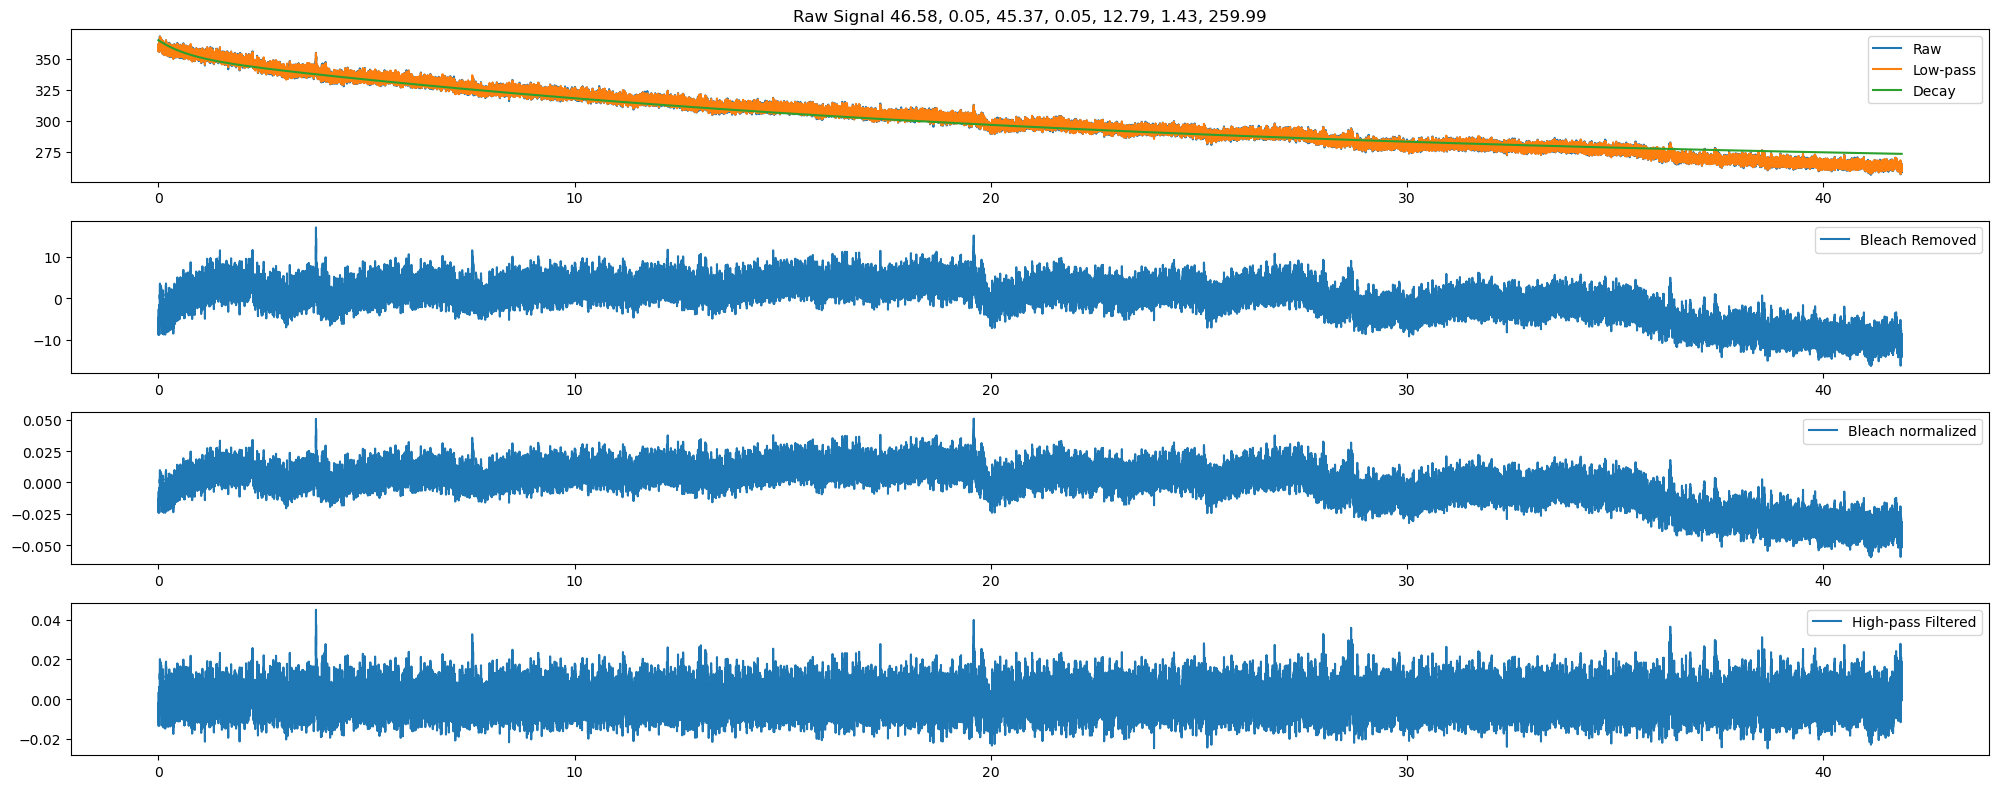

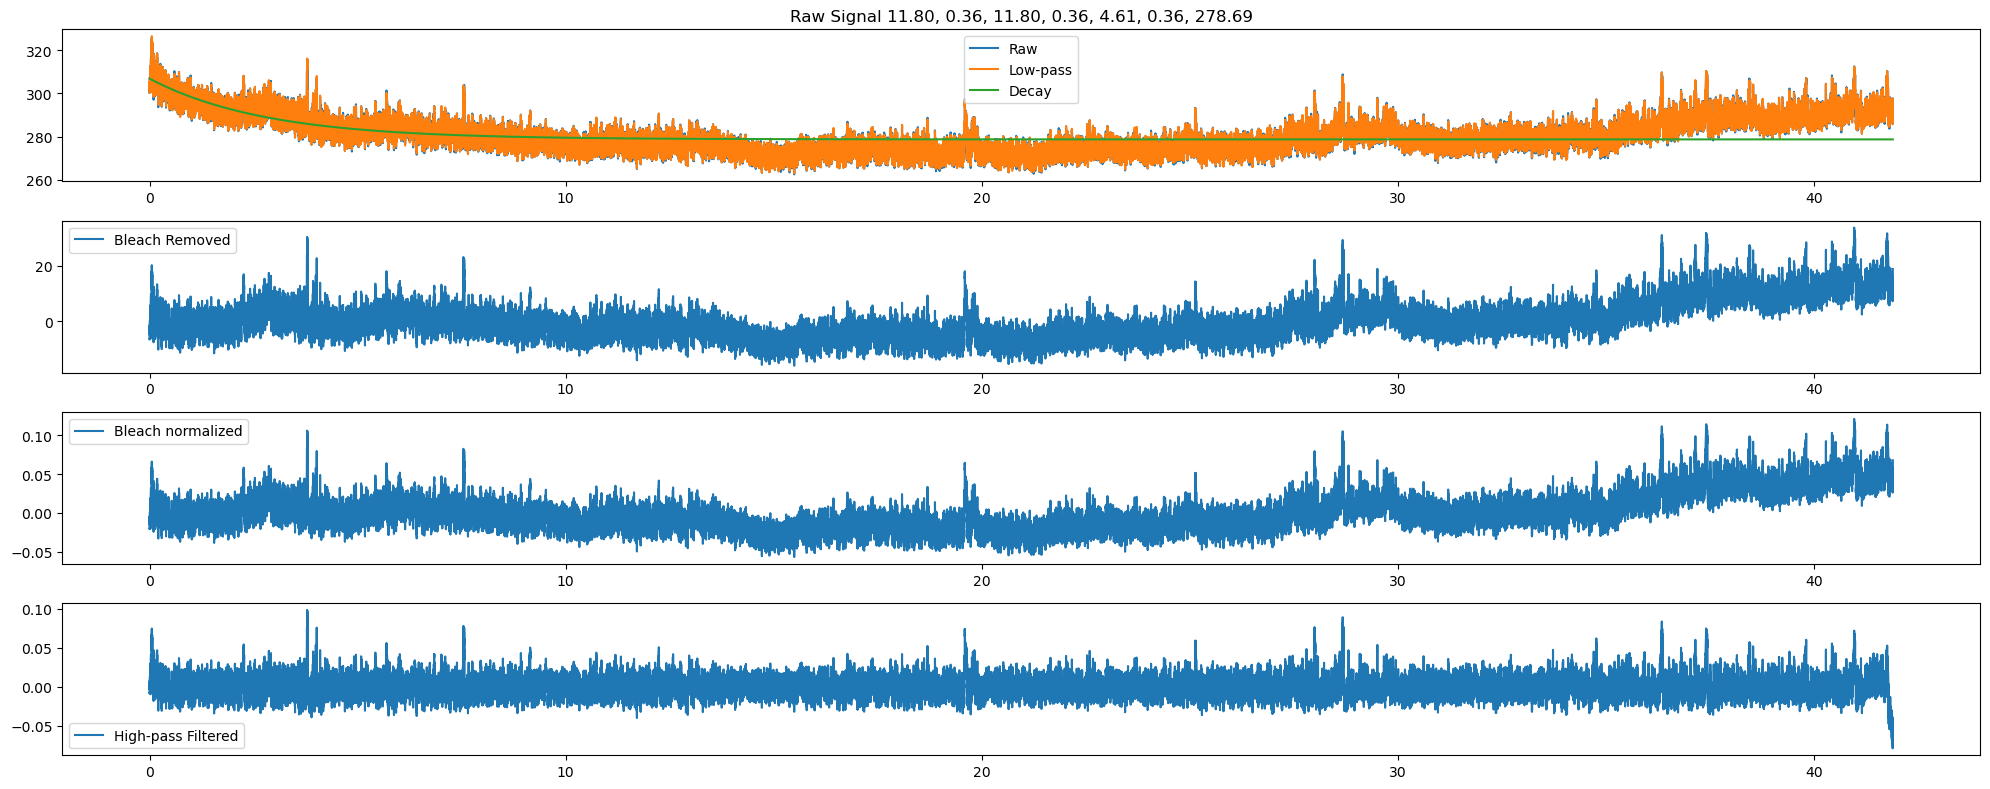

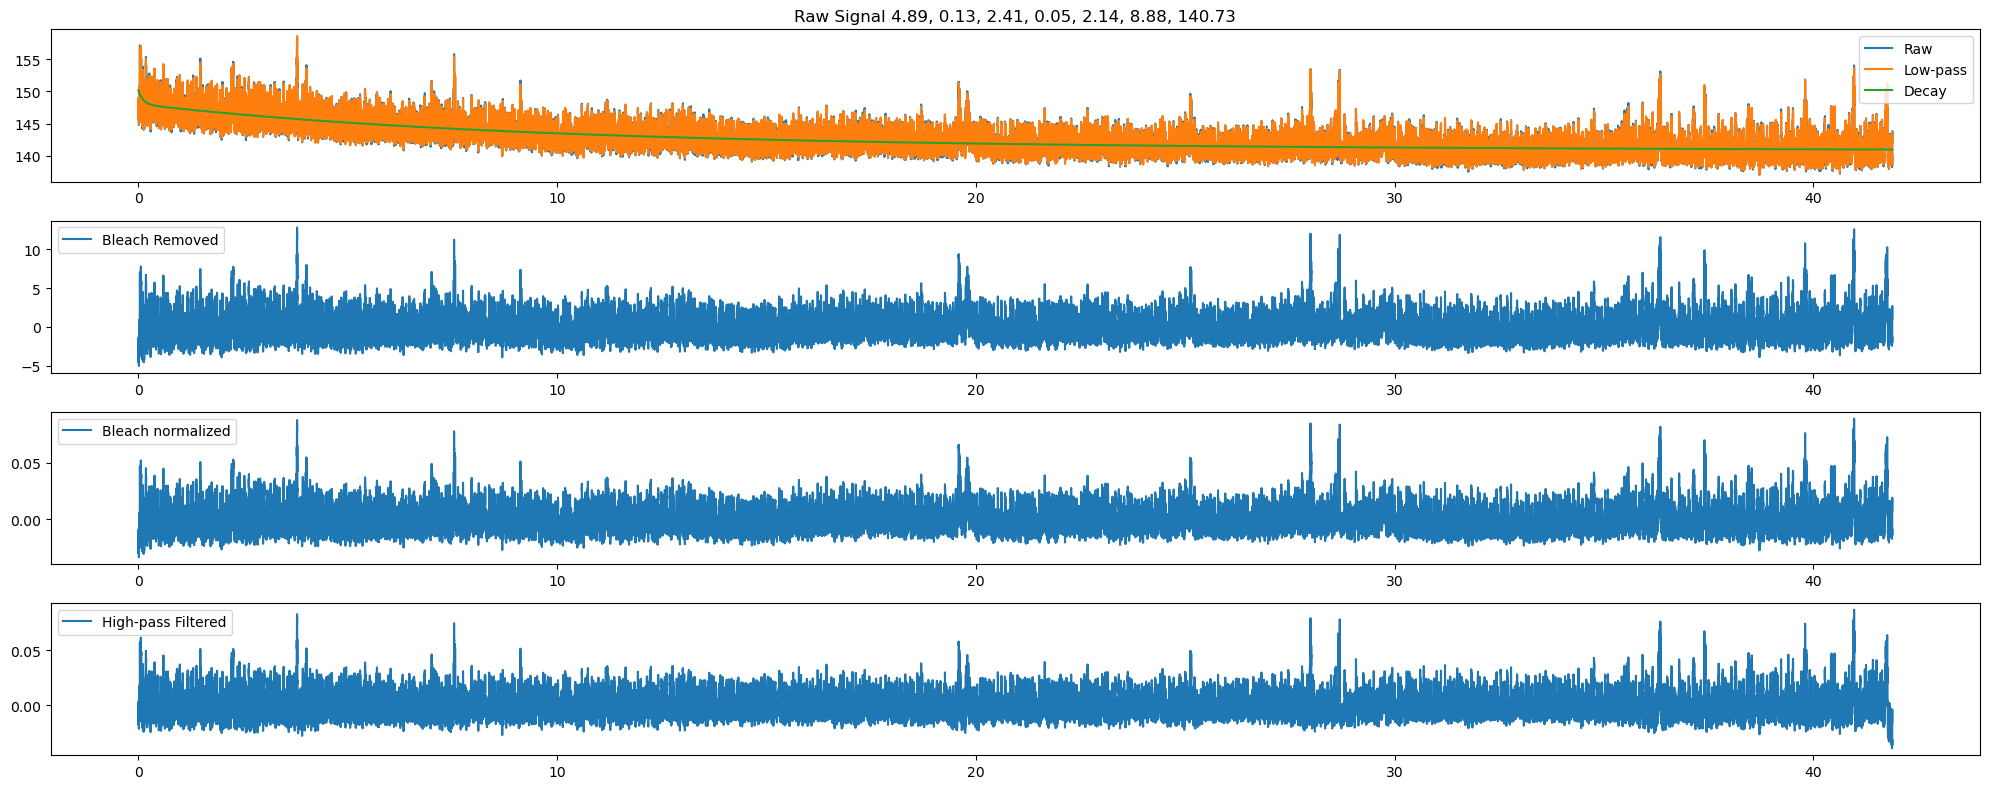

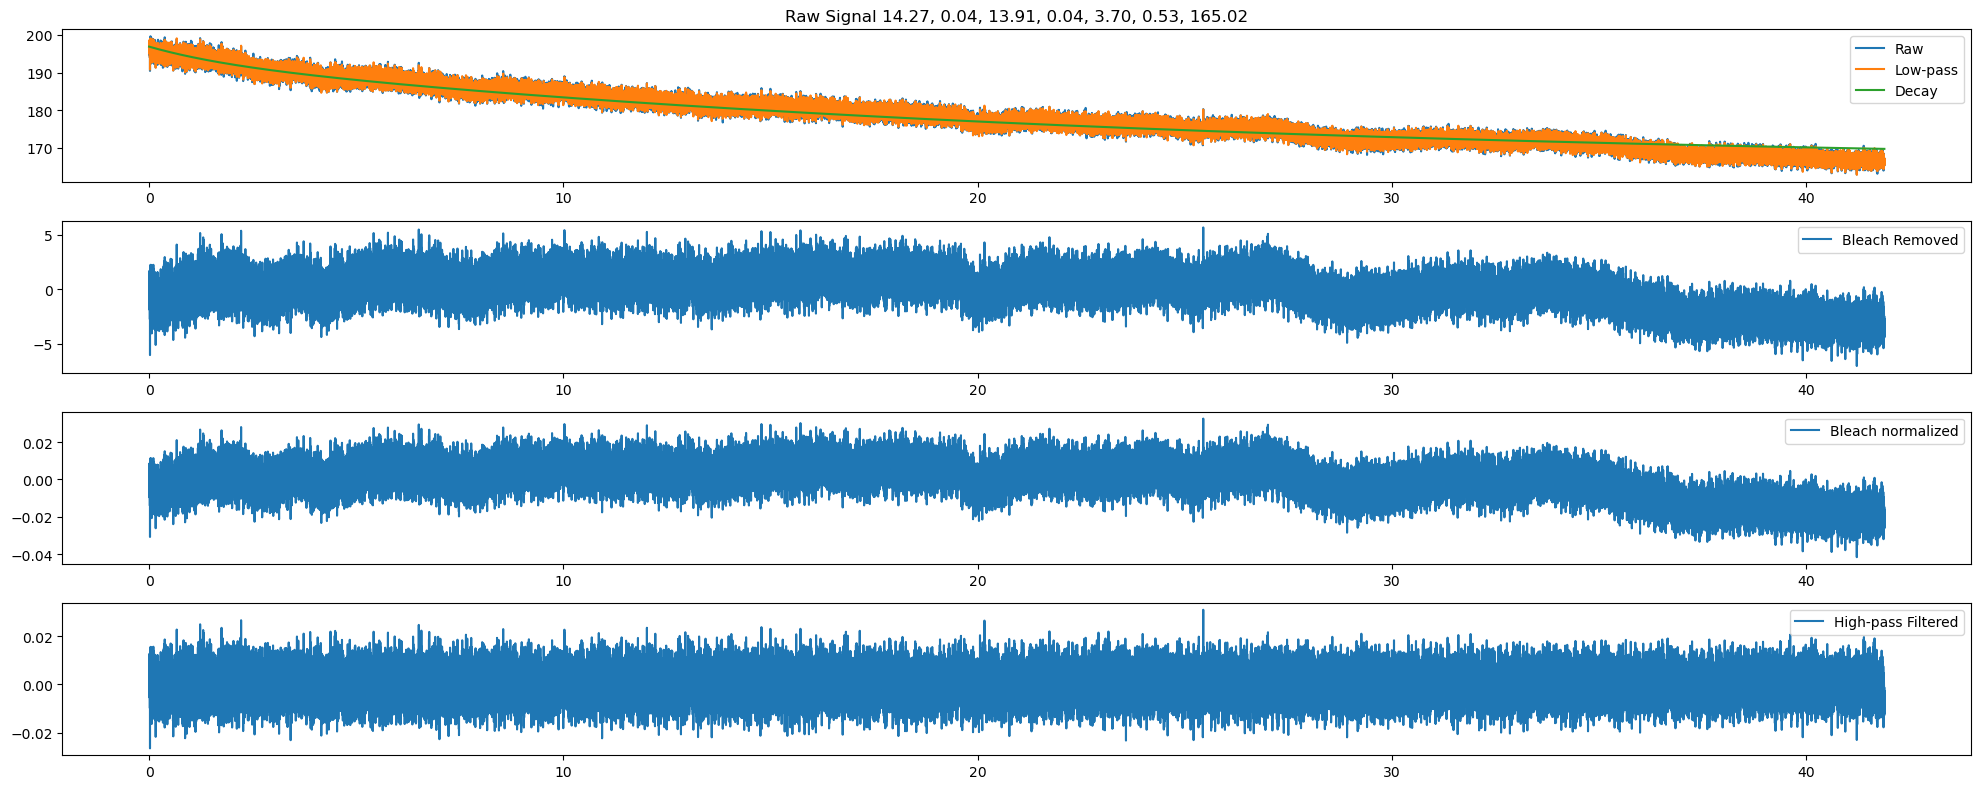

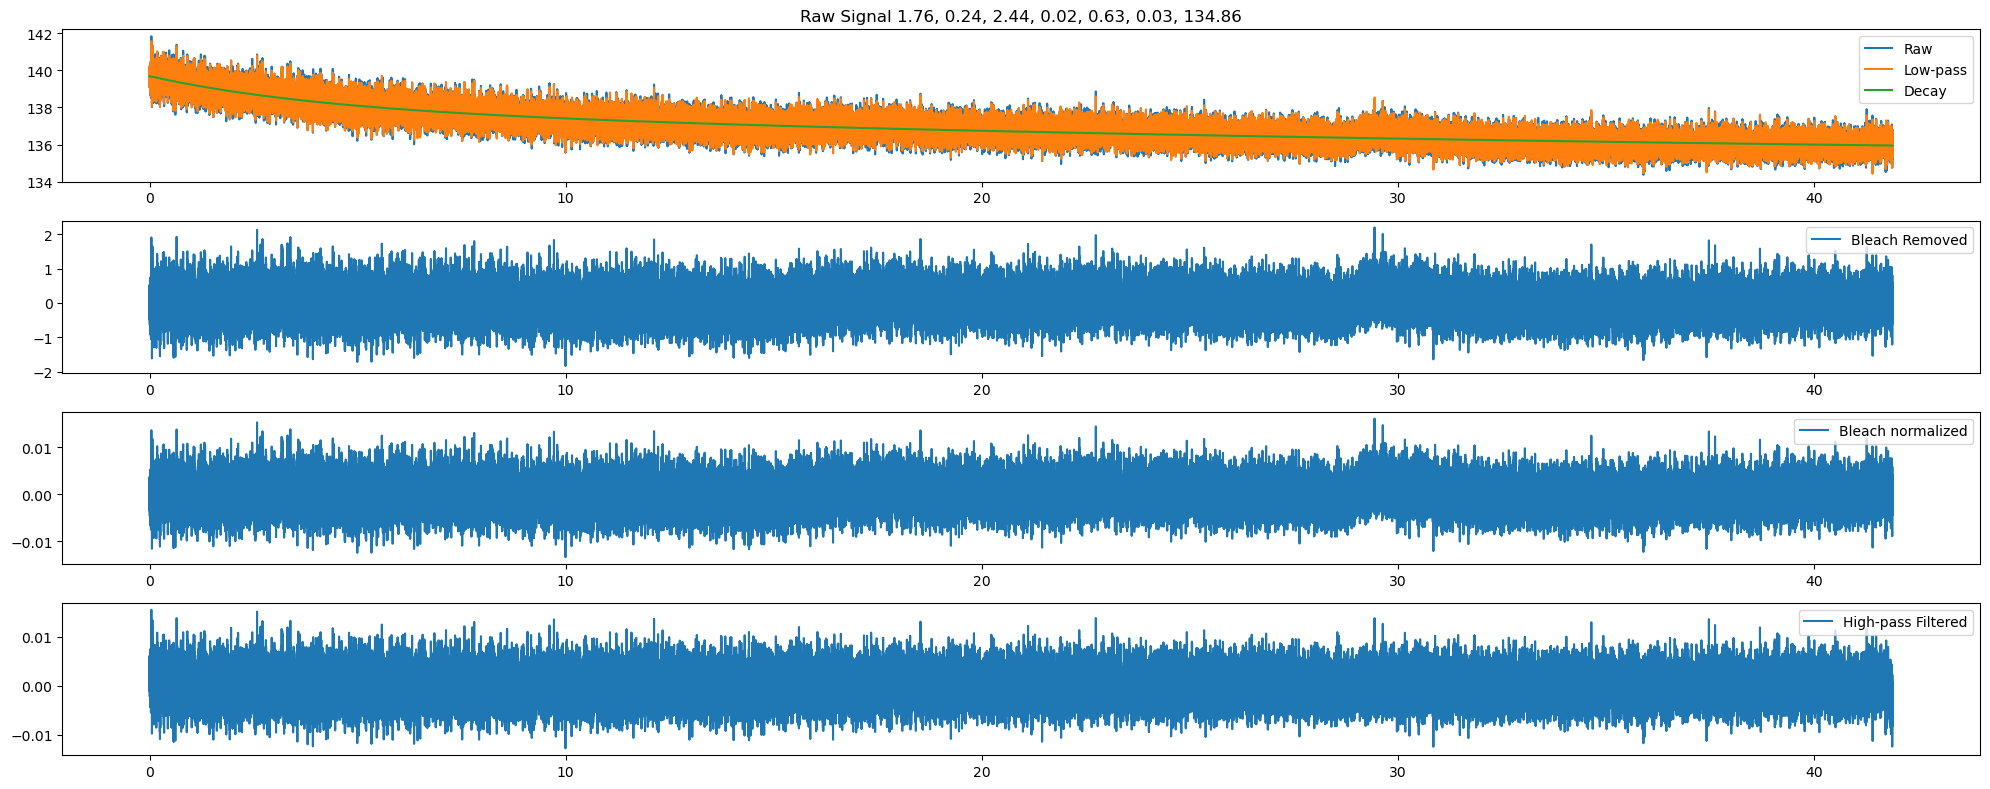

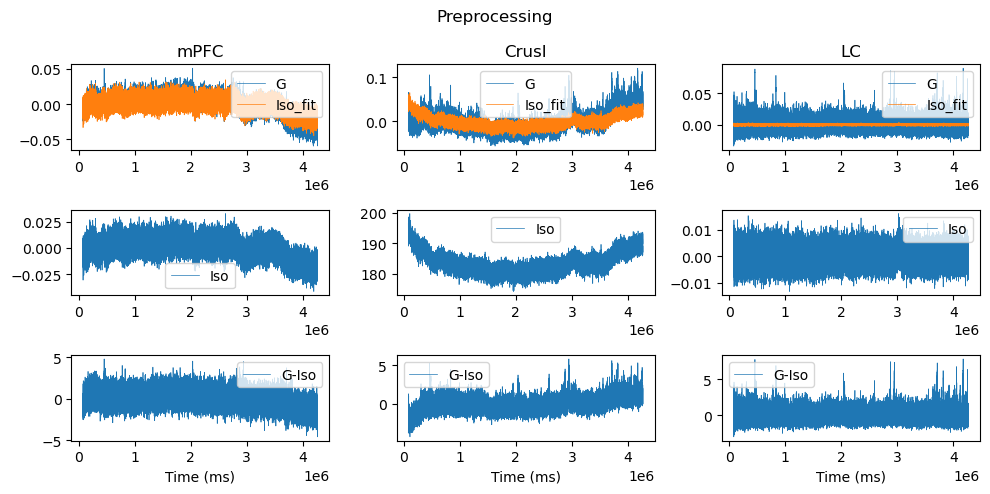

In [ ]:
session = 'm699462d20240113'
# label = 'Gi'
label = 'CombinewithKH'
beh, _,_ =load_session_df(session)
# signal_region_raw = load_session_FP_raw(session, label, plot=False);
signal_FP = load_session_FP(session, label)
signal_region_raw = load_session_FP_raw(session, label, plot=False);
signal_FP = preprocess_signal(session, signal_region_raw, xtol=1e-5, plot=True)
save_FP(signal_FP, session, tag = label)

In [25]:
save_FP(signal_FP, session, tag = label)

In [20]:
session.split('d')[0]

'm699462'

Current random number: 0.6187156132197922
0.0001


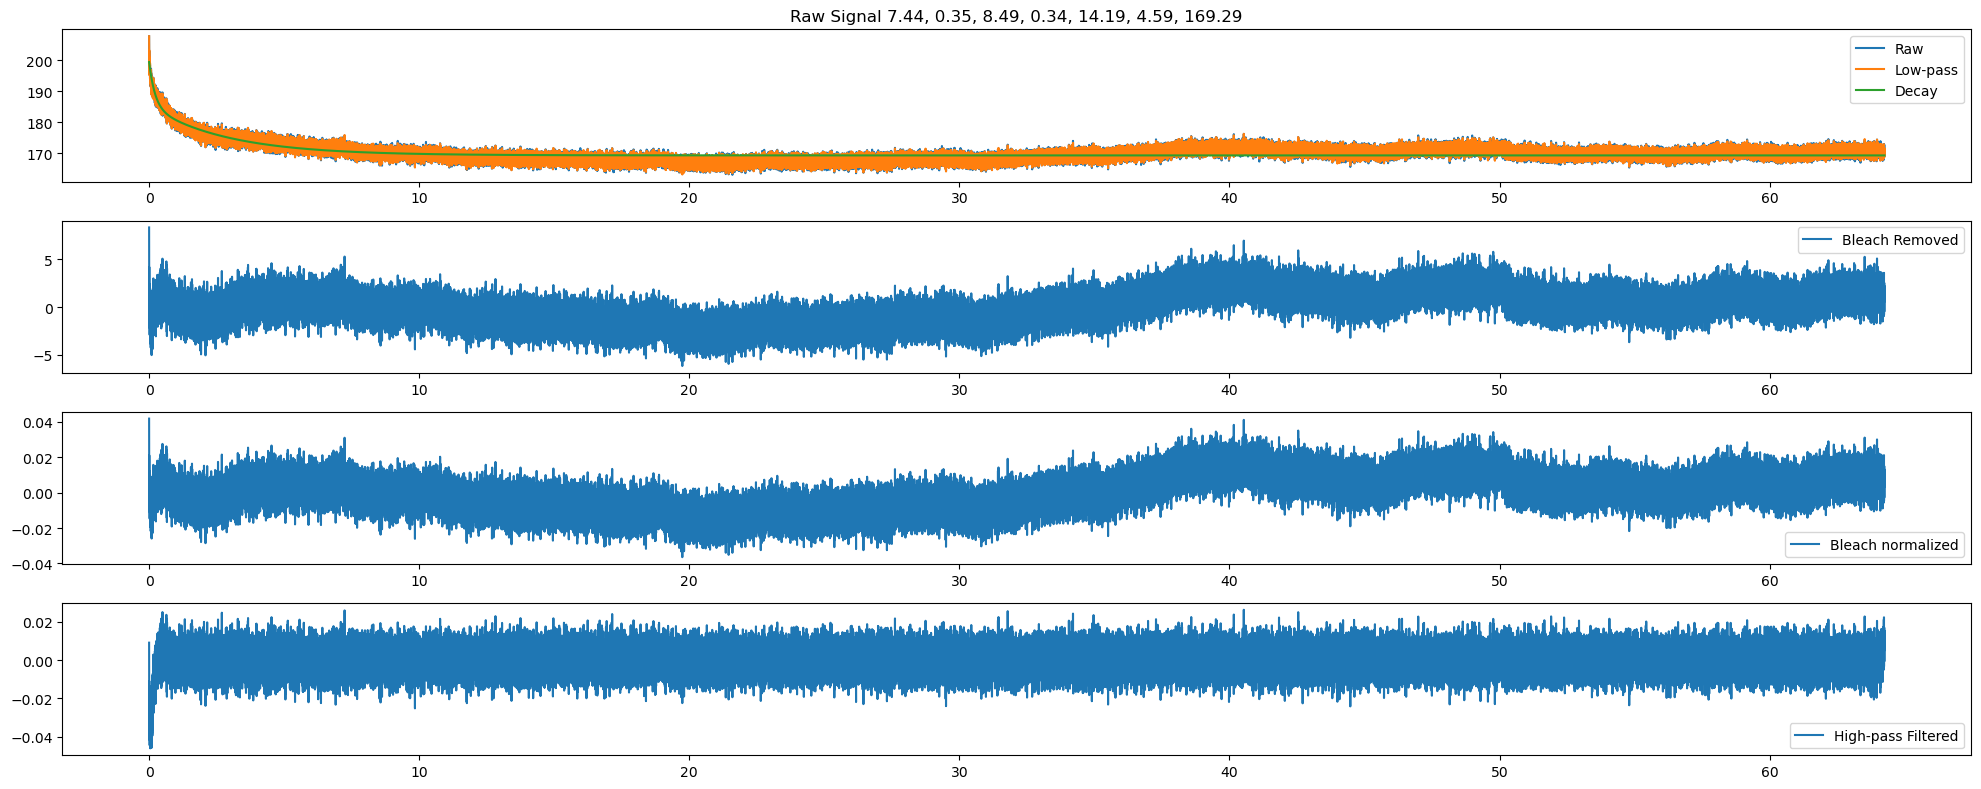

In [19]:
import random

# Generate a random number
current_random = random.random()  # Random float in [0, 1)
print("Current random number:", current_random)

signal = signal_region_raw['Iso']['CrusI']
signal_denoised = denoising(signal, fs = 20, fc = 9, xtol=1e-4, plot=True)

array([ 0.06629478,  0.04950677,  0.0461512 , ..., -0.00368474,
       -0.01093444,  0.01011761])

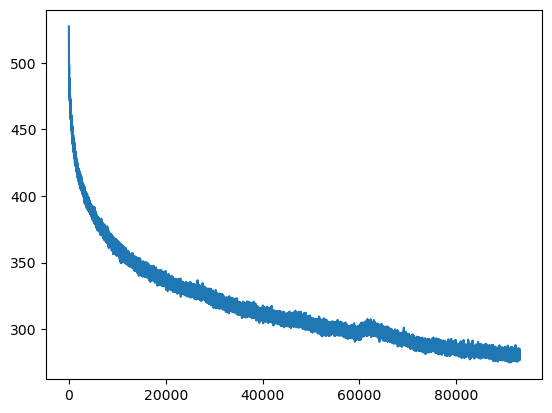

In [14]:
plt.plot(signal_region_raw['G']['CrusI'])
denoising(signal_region_raw['G']['CrusI'], fs = 20, fc = 9)

Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region TH recorded at fiber 1
Channel G:Region Gi recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region TH recorded at fiber 1
Channel Iso:Region Gi recorded at fiber 2
Region mPFC recorded at fiber 0
Region TH recorded at fiber 1
Region Gi recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region TH recorded at fiber 1
Channel G:Region Gi recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region TH recorded at fiber 1
Channel Iso:Region Gi recorded at fiber 2
Preprocessing GmPFC
Preprocessing GTH
Preprocessing GGi
Preprocessing IsomPFC
Preprocessing IsoTH
Preprocessing IsoGi
Created m754898d20250101_FP_Gi.pkl


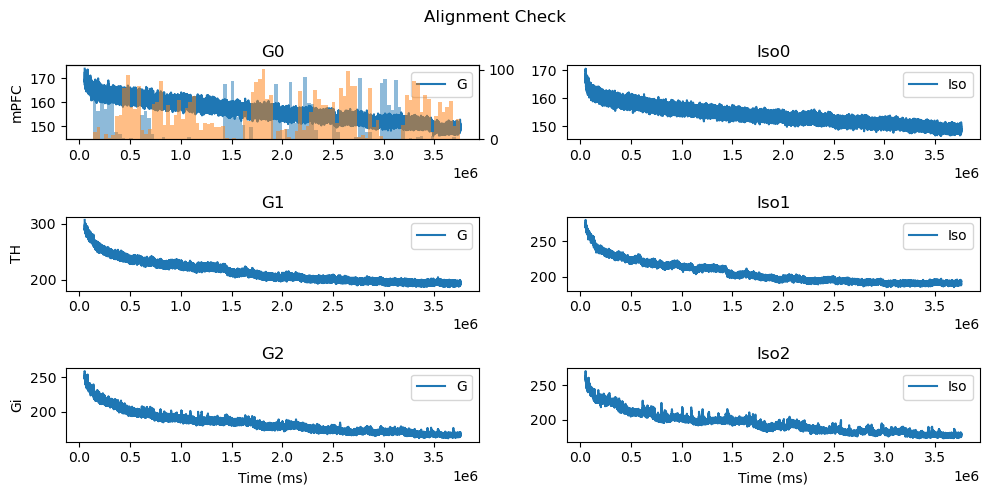

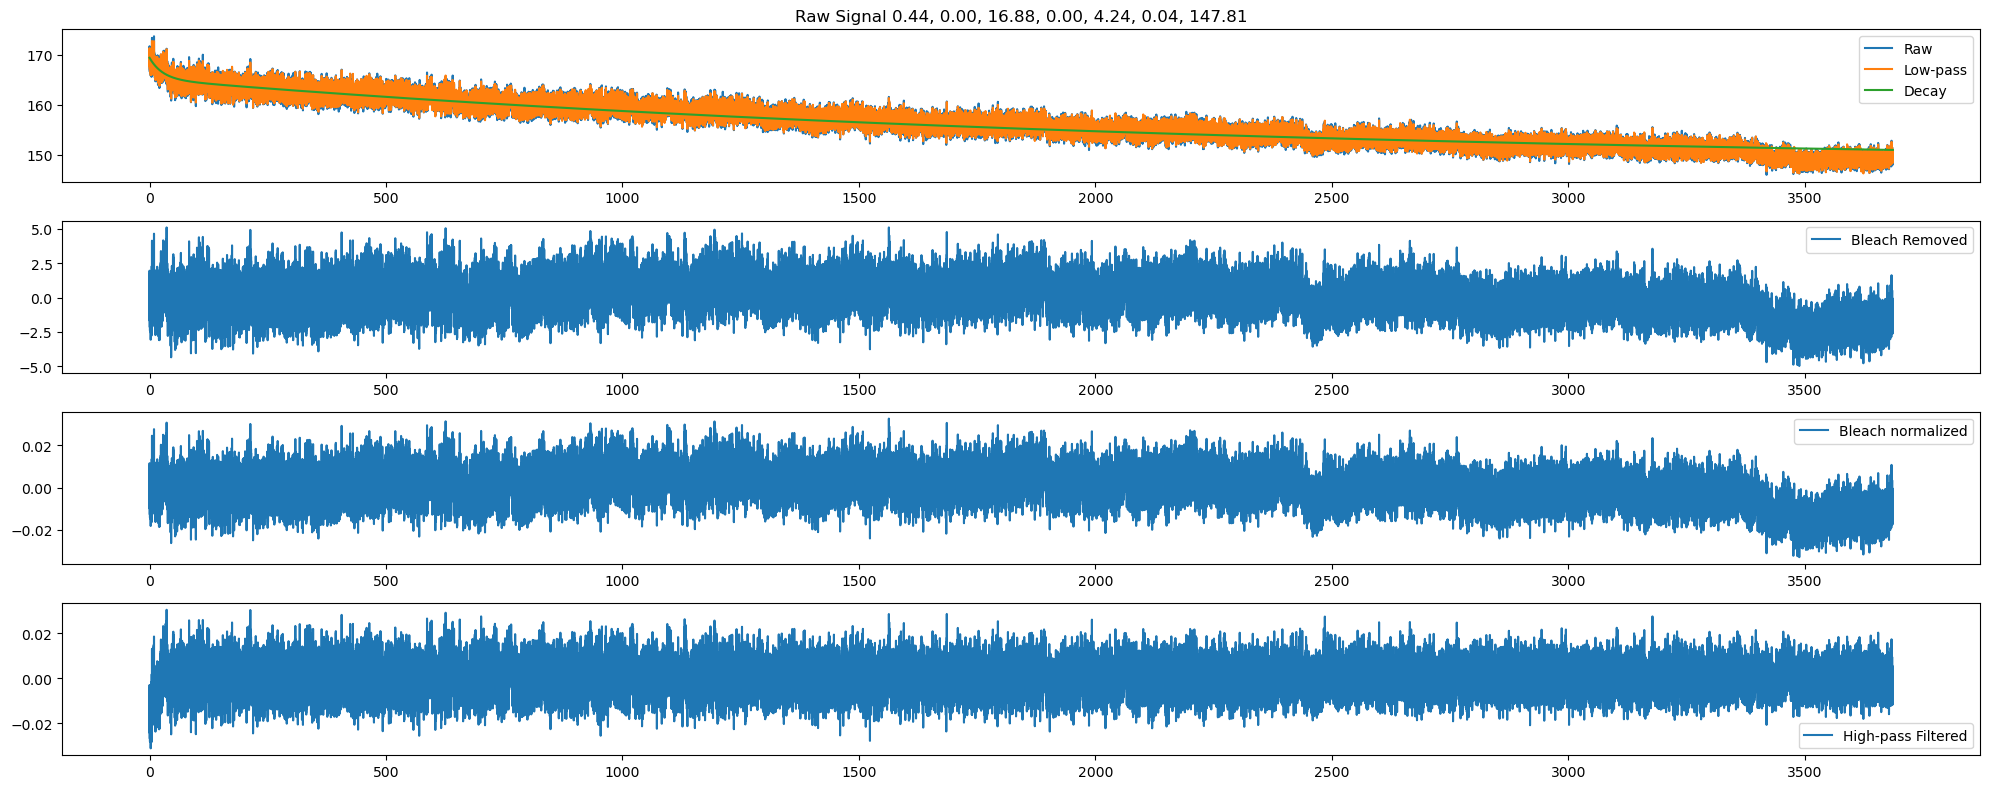

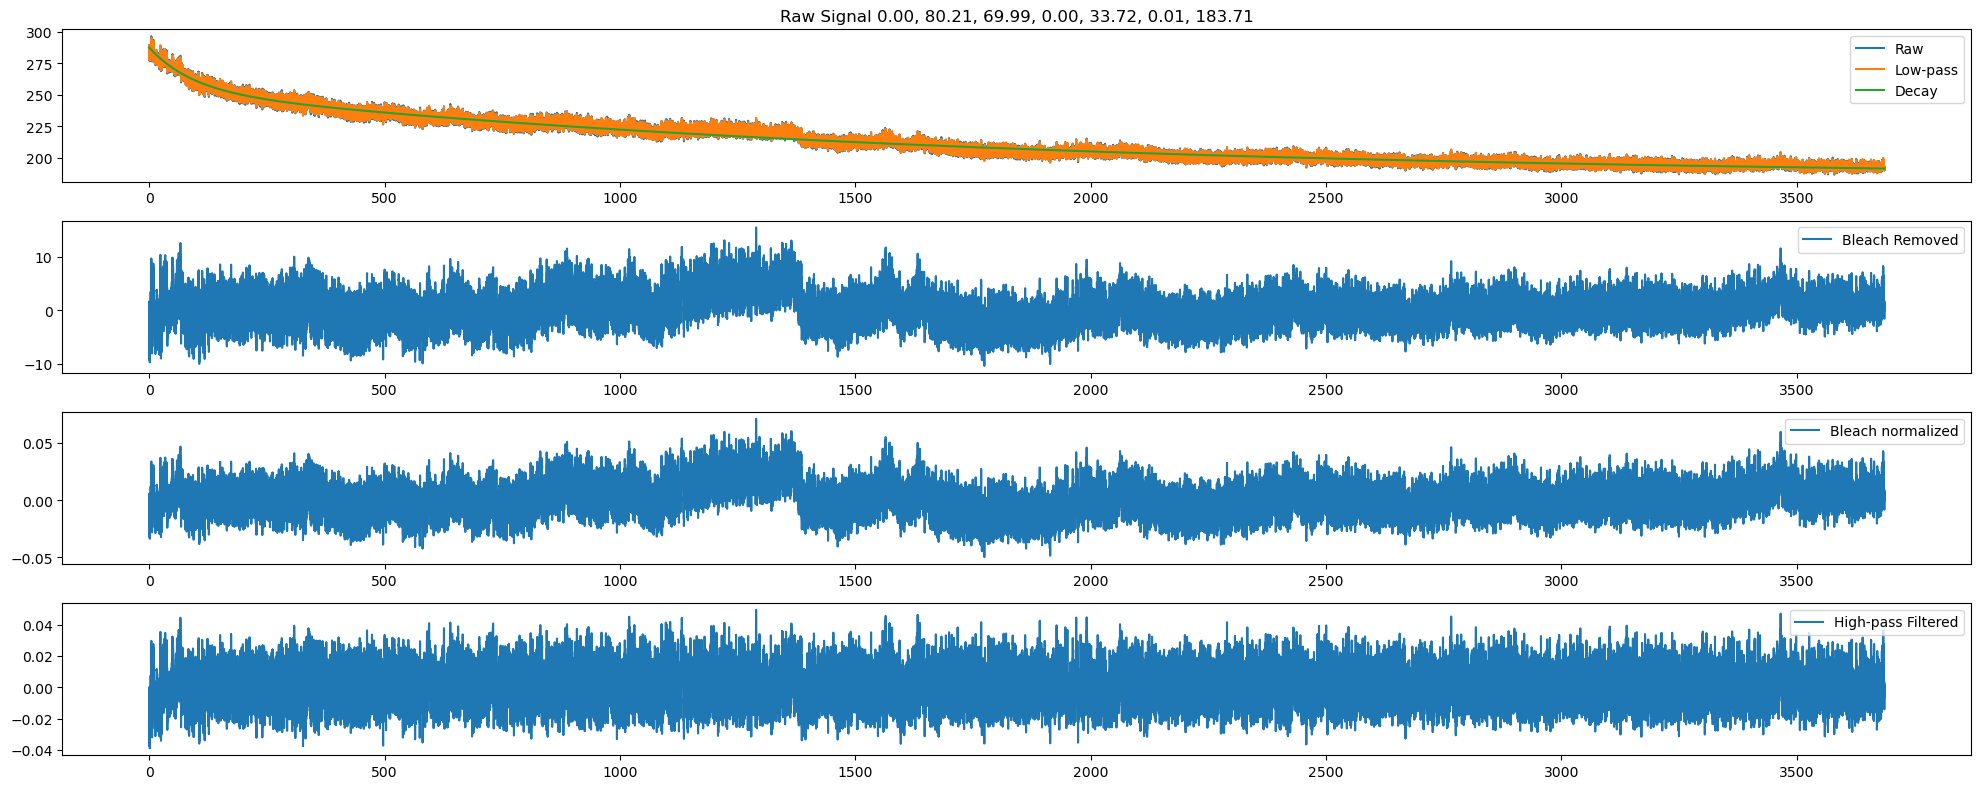

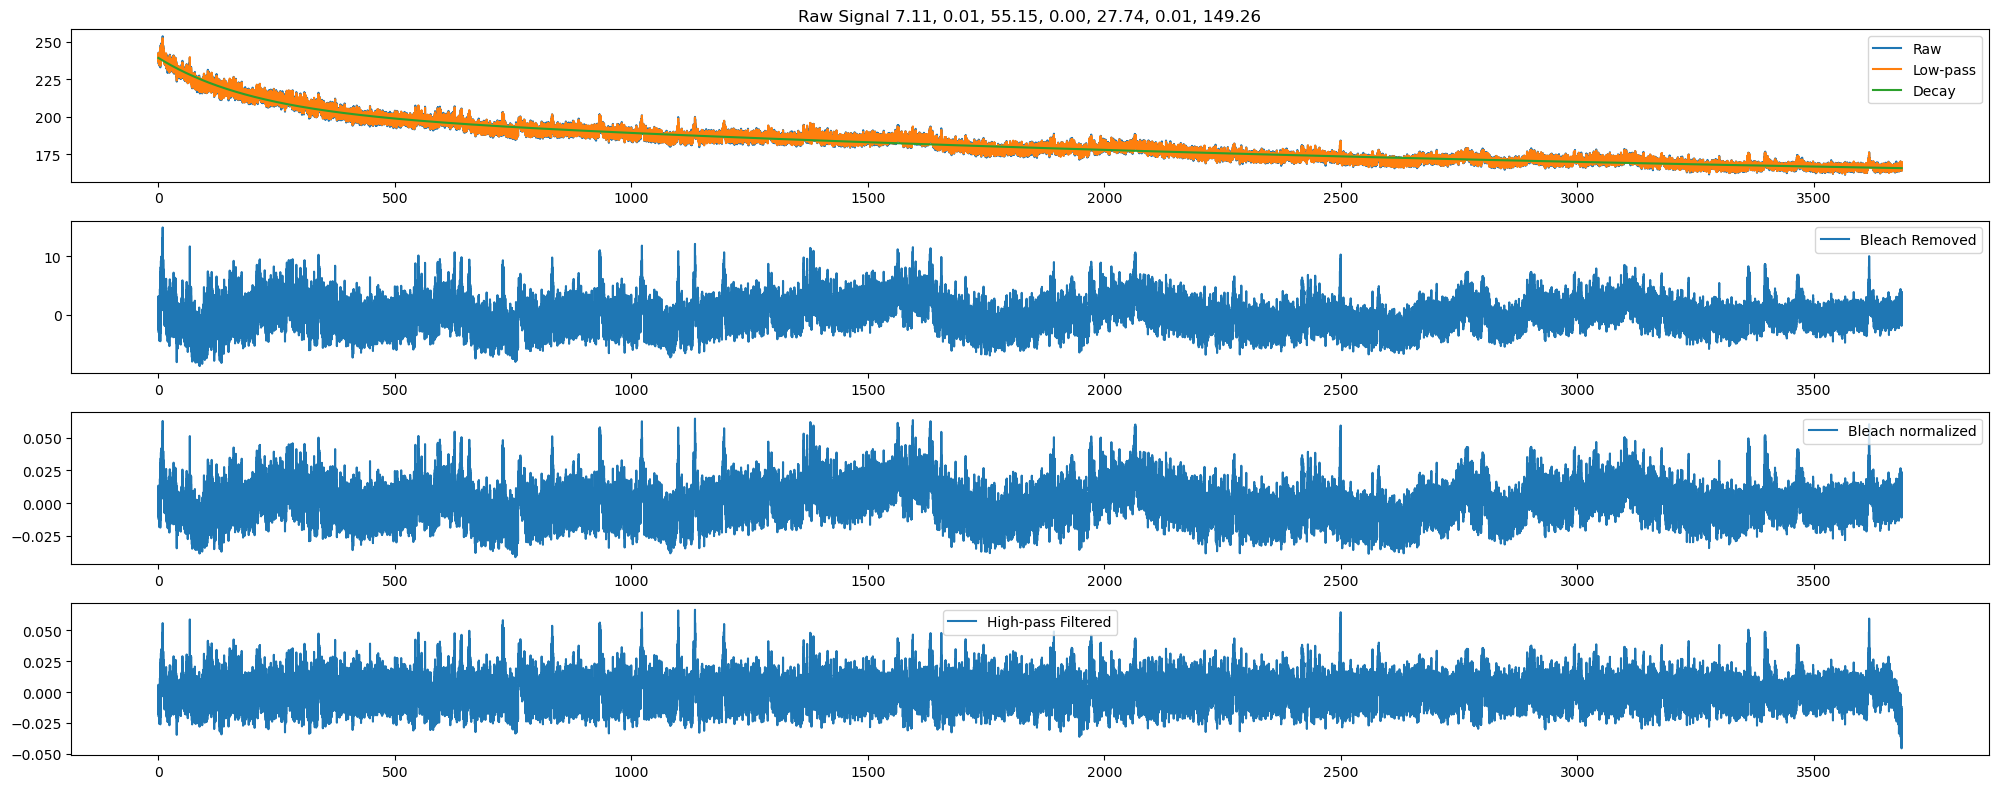

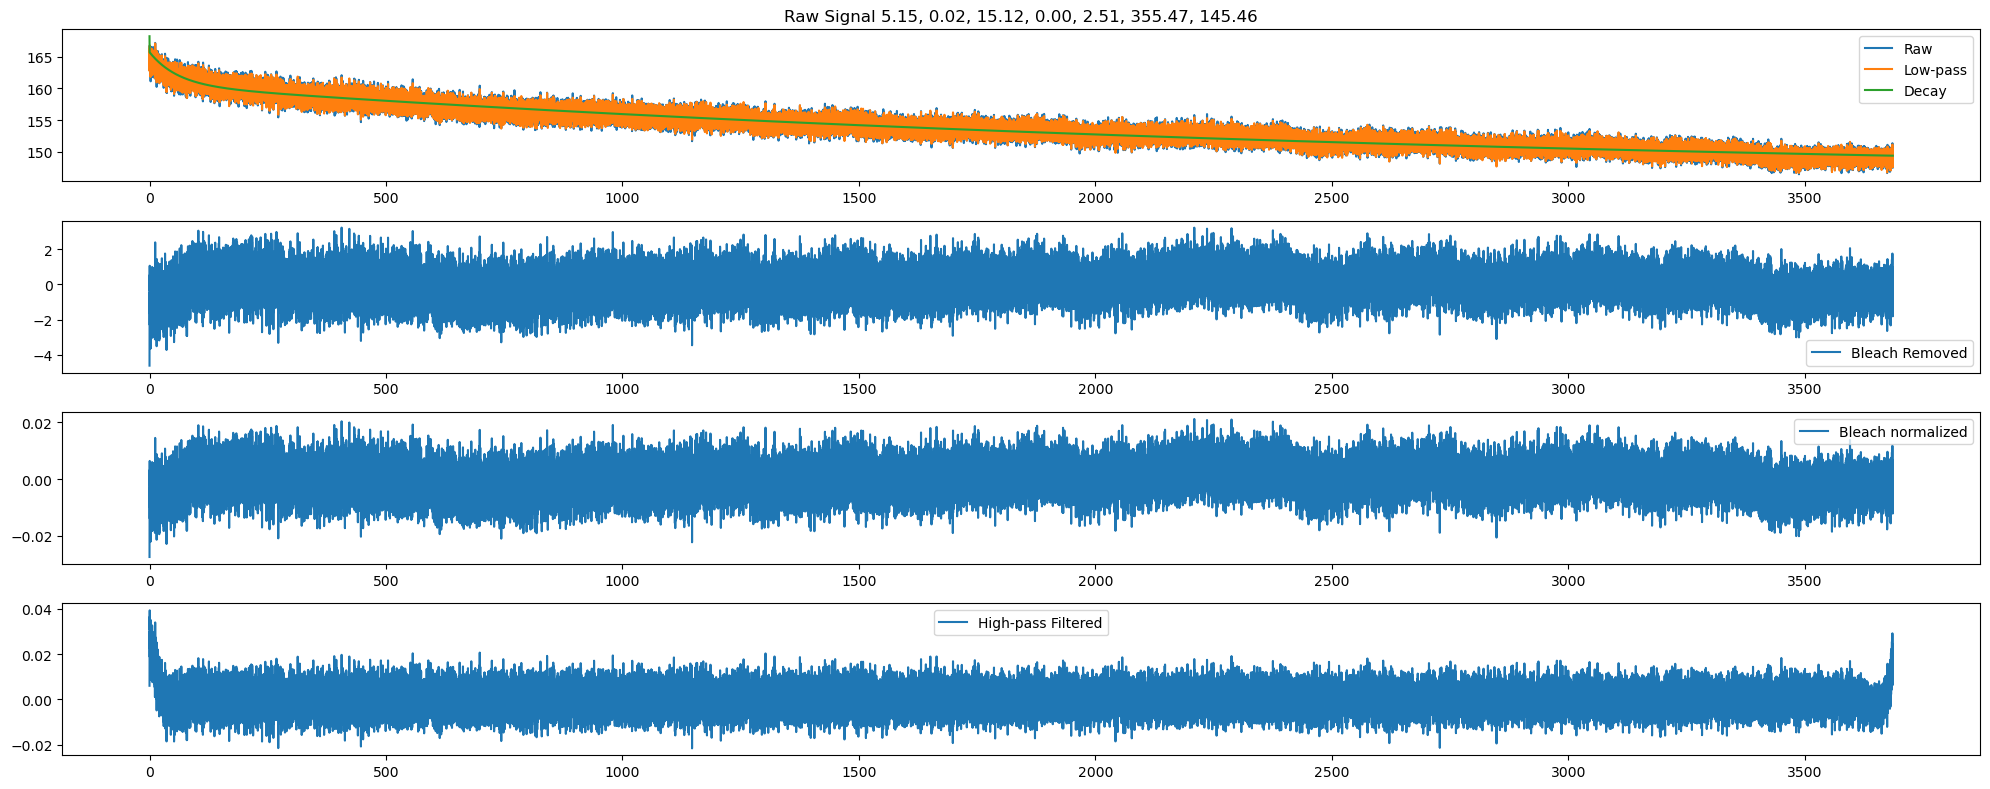

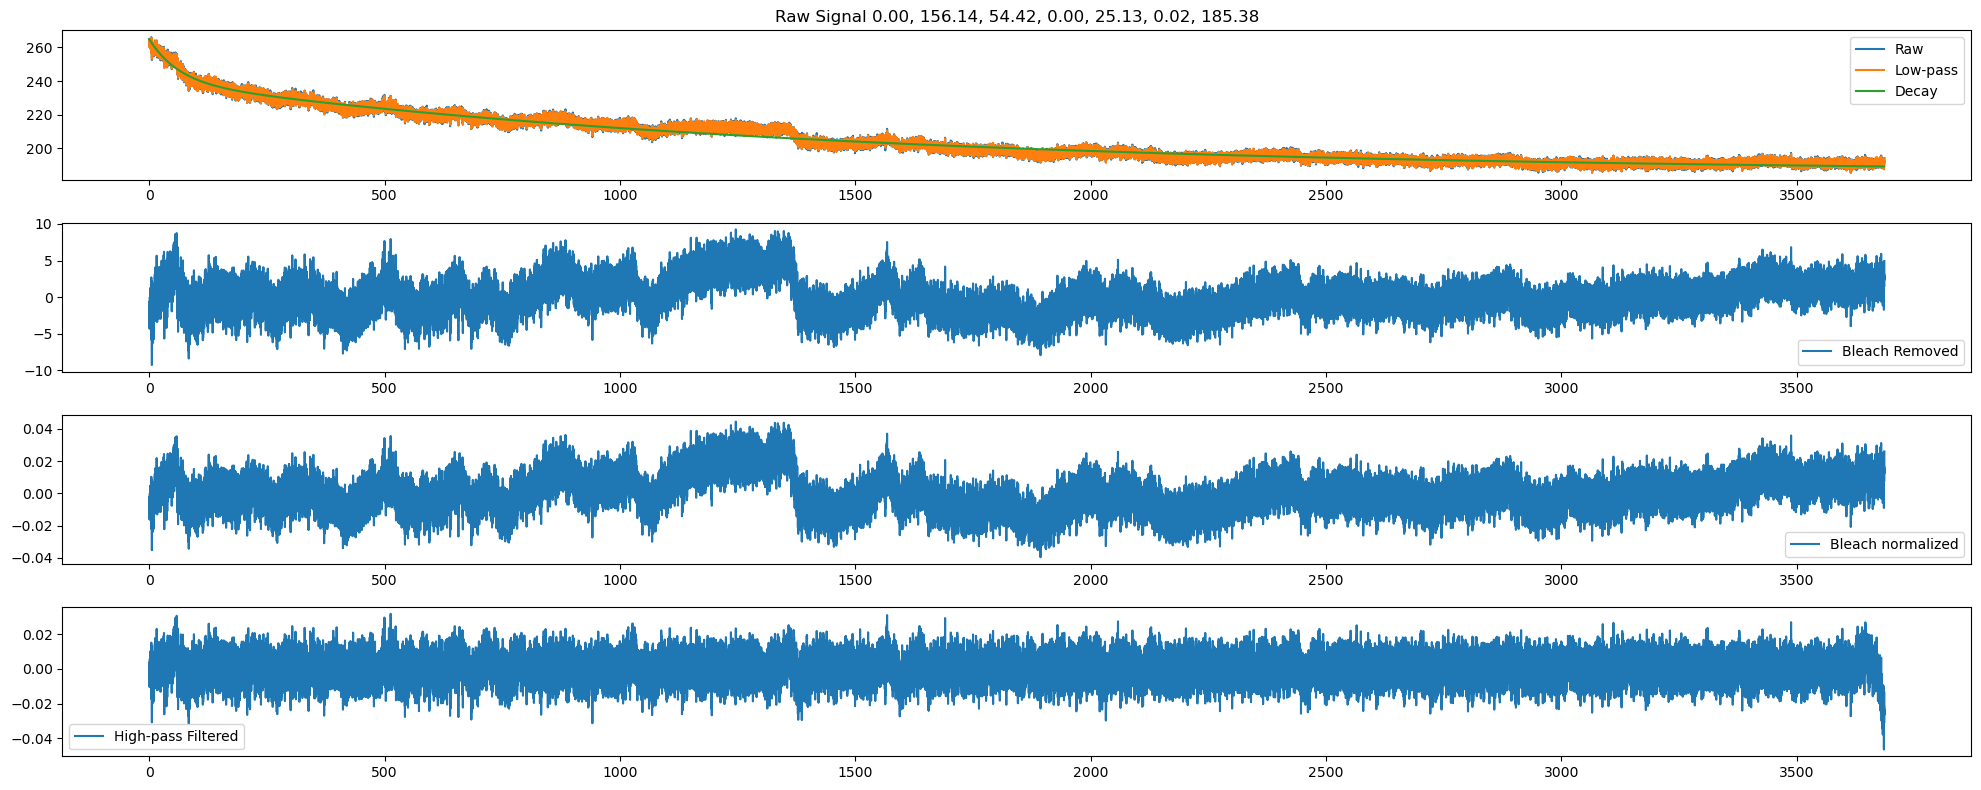

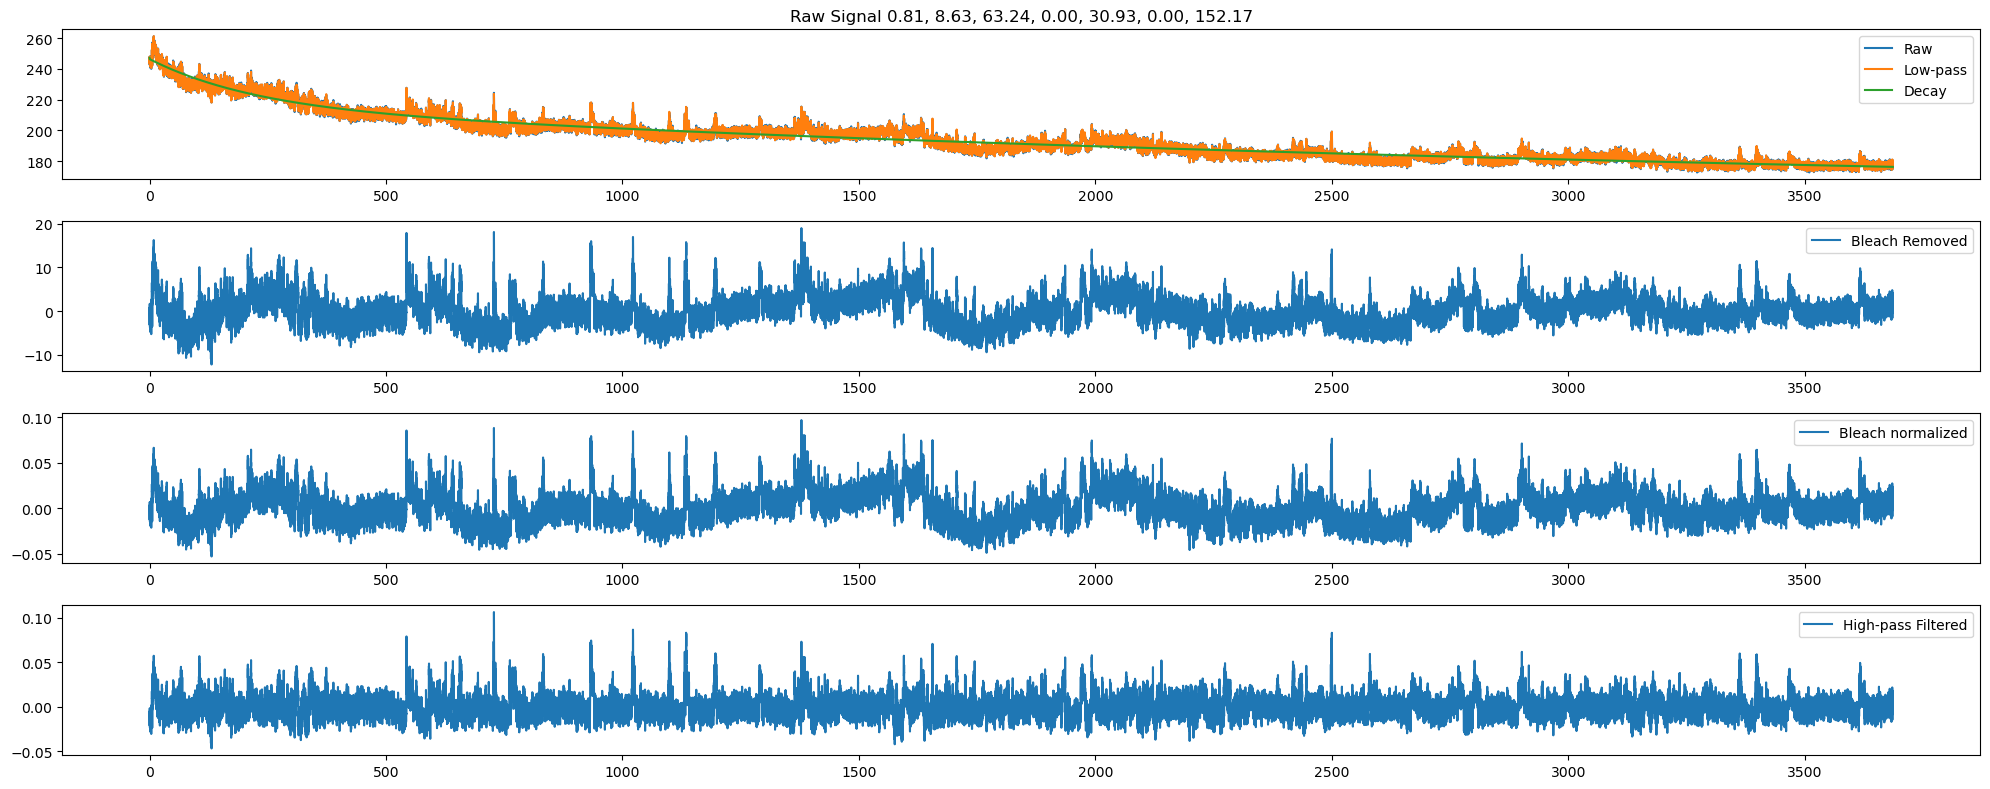

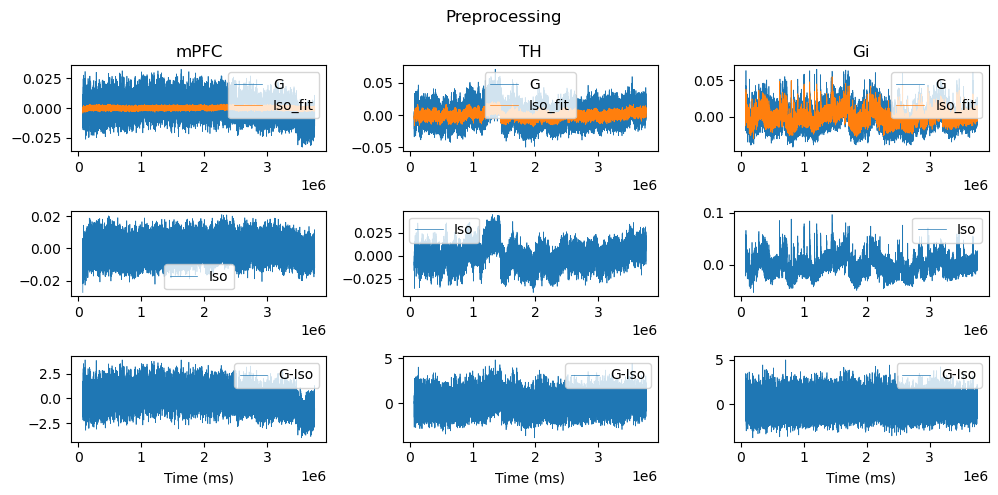

In [5]:
session = 'm754898d20250101'
label = 'Gi'
session_df, licks_L, licks_R = load_session_df(session)
session_dir = parse_session_string(session)
# signal_region_prep = get_FP_data(session, label)
# licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
# parsed_licks_L, _ = parse_lick_trains(licks_L)
# parsed_licks_R, _ = parse_lick_trains(licks_R)
signal_region_raw = load_session_FP_raw(session, label, plot=False);
signal = signal_region_raw['G']['Gi']
signal_region_prep = get_FP_data(session, label)

In [15]:
save_FP(signal_denoised, session, tag = label)

NameError: name 'signal_denoised' is not defined

In [20]:
for session in session_list:
    session_dir = parse_session_string(session)
    # write tmp_dict to json
    with open(os.path.join(session_dir['photometryPath'], f'{session}.json'), 'w') as f:
        json.dump(tmp_dict, f)
    print(f"Finished writing {session}.json")

Finished writing m699461d20231217.json
Finished writing m699461d20231218.json
Finished writing m699461d20231219.json
Finished writing m699461d20231220.json
Finished writing m699461d20231222.json
Finished writing m699461d20240102.json
Finished writing m699461d20240103.json
Finished writing m699461d20240104.json
Finished writing m699461d20240105.json
Finished writing m699461d20240106.json
Finished writing m699461d20240107.json
Finished writing m699461d20240116.json
Finished writing m699461d20240117.json
Finished writing m699462d20240103.json
Finished writing m699462d20240104.json
Finished writing m699462d20240106.json
Finished writing m699462d20240107.json
Finished writing m699462d20240108.json
Finished writing m699462d20240109.json
Finished writing m699462d20240111.json
Finished writing m699462d20240112.json
Finished writing m699462d20240113.json
Finished writing m699462d20240114.json
Finished writing m699462d20240116.json
Finished writing m699462d20240117.json
Finished writing m699472d